# Model Training

In [1]:
import itertools
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import holidays
import warnings
warnings.filterwarnings('ignore')
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gr
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import holidays

In [2]:
df=pd.read_csv("processed_full.csv")
df.head()

,date,quantity,month,day_of_month,is_month_start,is_month_end,day_of_year,week_of_year,day_of_week,year,...,lag_6,lag_7,rolling_mean_7,rolling_sum_7,rolling_std_7,rolling_mean_30,rolling_sum_30,rolling_std_30,expanding_sum,quantity_winsorized
0,2009-12-01,26434.0,12,1,1,0,335,49,2,2009,...,26434.0,26434.0,23710.571429,165974.0,14932.597372,17233.666667,517010.0,12220.541413,26434.0,26434.0
1,2009-12-02,31938.0,12,2,0,0,336,49,3,2009,...,26434.0,26434.0,23710.571429,165974.0,14932.597372,17233.666667,517010.0,12220.541413,58372.0,31938.0
2,2009-12-03,50898.0,12,3,0,0,337,49,4,2009,...,26434.0,26434.0,23710.571429,165974.0,14932.597372,17233.666667,517010.0,12220.541413,109270.0,50898.0
3,2009-12-04,21405.0,12,4,0,0,338,49,5,2009,...,26434.0,26434.0,23710.571429,165974.0,14932.597372,17233.666667,517010.0,12220.541413,130675.0,21405.0
4,2009-12-05,5119.0,12,5,0,0,339,49,6,2009,...,26434.0,26434.0,23710.571429,165974.0,14932.597372,17233.666667,517010.0,12220.541413,135794.0,5119.0


In [3]:
df.index =df["date"]
df.head(2)

,date,quantity,month,day_of_month,is_month_start,is_month_end,day_of_year,week_of_year,day_of_week,year,...,lag_6,lag_7,rolling_mean_7,rolling_sum_7,rolling_std_7,rolling_mean_30,rolling_sum_30,rolling_std_30,expanding_sum,quantity_winsorized
date,,,,,,,,,,,,,,,,,,,,,
2009-12-01,2009-12-01,26434.0,12,1,1,0,335,49,2,2009,...,26434.0,26434.0,23710.571429,165974.0,14932.597372,17233.666667,517010.0,12220.541413,26434.0,26434.0
2009-12-02,2009-12-02,31938.0,12,2,0,0,336,49,3,2009,...,26434.0,26434.0,23710.571429,165974.0,14932.597372,17233.666667,517010.0,12220.541413,58372.0,31938.0


In [4]:
data = df.copy()
data["ds"] = df.index
data["y"] = df["quantity_winsorized"]
data['ds'] = pd.to_datetime(data['ds'])
data.drop(columns=['date'],inplace=True)

# Machine Learning Models

LightGBM - MAE: 5643.7699, MAPE: 22.8347%
XGBoost - MAE: 5420.9825, MAPE: 21.0422%
RandomForest - MAE: 4956.1308, MAPE: 20.2581%

The best model is RandomForest with a MAPE of 20.2581%


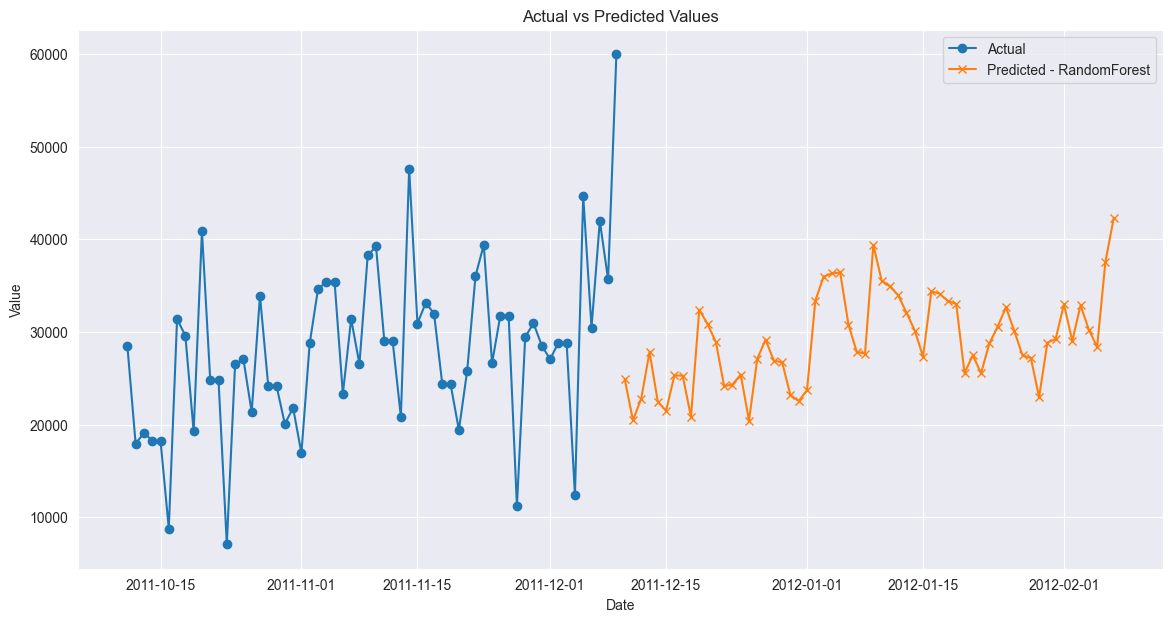

In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import holidays

# Make a copy of the dataframe
rml_data = data.copy()

# Ensure 'ds' column is datetime
rml_data['ds'] = pd.to_datetime(rml_data['ds'])

# Define features and target
features = ['month', 'day_of_month', 'is_month_start', 'is_month_end',
            'day_of_year', 'week_of_year', 'day_of_week', 'year',
            'is_weekend', 'is_spring', 'is_summer', 'is_fall', 'is_winter',
            'sin_day', 'cos_day', 'is_public_holiday', 'lag_1', 'lag_2', 
            'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'rolling_mean_7', 
            'rolling_sum_7', 'rolling_std_7', 'rolling_mean_30', 
            'rolling_sum_30', 'rolling_std_30', 'expanding_sum']

target = 'y'

# Split the data into train and test sets
train_df = rml_data[:-60]
test_df = rml_data[-60:]

X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

# Define the models
models = {
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, verbosity=-1),
    'XGBoost': XGBRegressor(n_estimators=100, verbosity=0),
    'RandomForest': RandomForestRegressor(n_estimators=100)
}

# Initialize lists to store the scores
mae_scores = {}
mape_scores = {}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    mae_scores[model_name] = mae
    mape_scores[model_name] = mape
    
    print(f"{model_name} - MAE: {mae:.4f}, MAPE: {mape:.4%}")

# Select the best model based on MAPE
best_model_name = min(mape_scores, key=mape_scores.get)
best_model = models[best_model_name]
print(f"\nThe best model is {best_model_name} with a MAPE of {mape_scores[best_model_name]:.4%}")

# Retrain the best model on the entire dataset
best_model.fit(rml_data[features], rml_data[target])

# Predict the next 60 days
future_dates = pd.date_range(start=rml_data['ds'].max() + pd.Timedelta(days=1), periods=60, freq='D')
future_df = pd.DataFrame({
    'ds': future_dates,
    'month': future_dates.month,
    'day_of_month': future_dates.day,
    'is_month_start': future_dates.is_month_start.astype(int),
    'is_month_end': future_dates.is_month_end.astype(int),
    'day_of_year': future_dates.dayofyear,
    'week_of_year': future_dates.isocalendar().week,
    'day_of_week': future_dates.dayofweek + 1,
    'year': future_dates.year,
    'is_weekend': (future_dates.weekday >= 5).astype(int),
    'is_spring': future_dates.month.isin([3, 4, 5]).astype(int),
    'is_summer': future_dates.month.isin([6, 7, 8]).astype(int),
    'is_fall': future_dates.month.isin([9, 10, 11]).astype(int),
    'is_winter': future_dates.month.isin([12, 1, 2]).astype(int),
    'sin_day': np.sin(2 * np.pi * future_dates.dayofweek / 7),
    'cos_day': np.cos(2 * np.pi * future_dates.dayofweek / 7)
})

# Add public holidays for the future dates
uk_holidays = holidays.UK()
future_df['is_public_holiday'] = future_df['ds'].apply(lambda date: 1 if date in uk_holidays else 0)

# Add lag features and rolling statistics for the future_df
for lag in range(1, 8):
    future_df[f'lag_{lag}'] = rml_data[target].shift(lag).iloc[-60:].values

for window in [7, 30]:
    future_df[f'rolling_mean_{window}'] = rml_data[target].rolling(window=window).mean().iloc[-60:].values
    future_df[f'rolling_sum_{window}'] = rml_data[target].rolling(window=window).sum().iloc[-60:].values
    future_df[f'rolling_std_{window}'] = rml_data[target].rolling(window=window).std().iloc[-60:].values

future_df['expanding_sum'] = rml_data[target].expanding().sum().iloc[-60:].values

# Predict future values using the best model
future_predictions = best_model.predict(future_df[features])

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test_df['ds'], test_df['y'], label='Actual', marker='o')
plt.plot(future_df['ds'], future_predictions, label=f'Predicted - {best_model_name}', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


### Reduce forecast horizon to 30 days

LightGBM - MAE: 5828.2964, MAPE: 20.4454%
XGBoost - MAE: 5763.8342, MAPE: 18.6083%
RandomForest - MAE: 4925.5673, MAPE: 16.2701%

The best model is RandomForest with a MAPE of 16.2701%


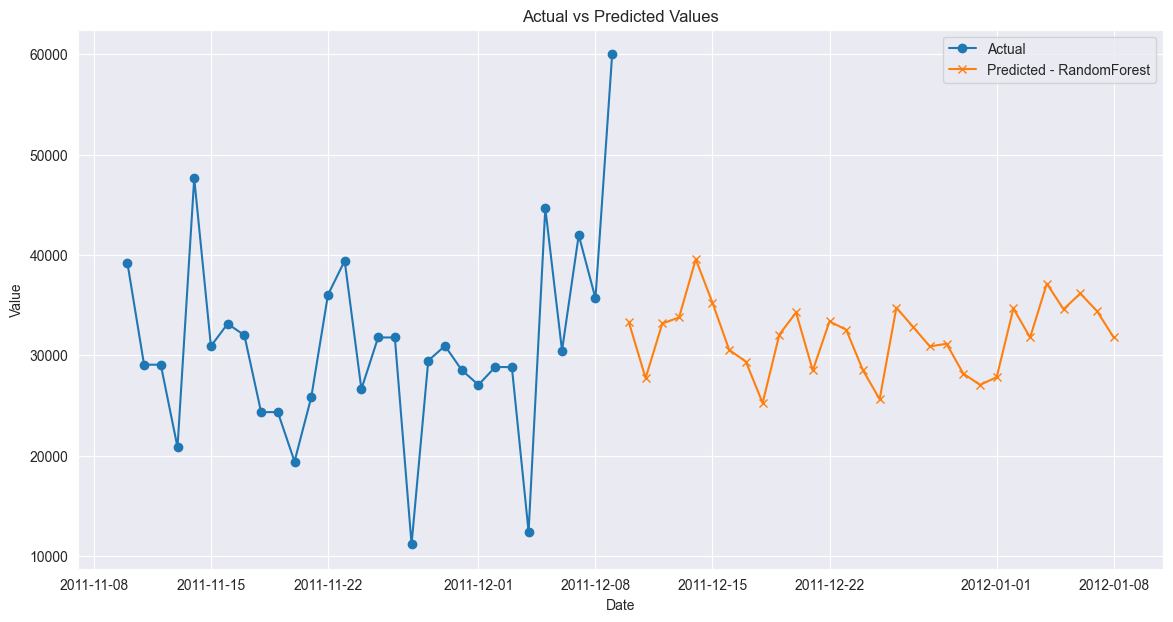

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import holidays

# Make a copy of the dataframe
rml_data = data.copy()

# Ensure 'ds' column is datetime
rml_data['ds'] = pd.to_datetime(rml_data['ds'])

# Define features and target
features = ['month', 'day_of_month', 'is_month_start', 'is_month_end',
            'day_of_year', 'week_of_year', 'day_of_week', 'year',
            'is_weekend', 'is_spring', 'is_summer', 'is_fall', 'is_winter',
            'sin_day', 'cos_day', 'is_public_holiday', 'lag_1', 'lag_2', 
            'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'rolling_mean_7', 
            'rolling_sum_7', 'rolling_std_7', 'rolling_mean_30', 
            'rolling_sum_30', 'rolling_std_30', 'expanding_sum']

target = 'y'

# Split the data into train and test sets
train_df = rml_data[:-30]
test_df = rml_data[-30:]

X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

# Define the models
models = {
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, verbosity=-1),
    'XGBoost': XGBRegressor(n_estimators=100, verbosity=0),
    'RandomForest': RandomForestRegressor(n_estimators=100)
}

# Initialize lists to store the scores
mae_scores = {}
mape_scores = {}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    mae_scores[model_name] = mae
    mape_scores[model_name] = mape
    
    print(f"{model_name} - MAE: {mae:.4f}, MAPE: {mape:.4%}")

# Select the best model based on MAPE
best_model_name = min(mape_scores, key=mape_scores.get)
best_model = models[best_model_name]
print(f"\nThe best model is {best_model_name} with a MAPE of {mape_scores[best_model_name]:.4%}")

# Retrain the best model on the entire dataset
best_model.fit(rml_data[features], rml_data[target])

# Predict the next 30 days
future_dates = pd.date_range(start=rml_data['ds'].max() + pd.Timedelta(days=1), periods=30, freq='D')
future_df = pd.DataFrame({
    'ds': future_dates,
    'month': future_dates.month,
    'day_of_month': future_dates.day,
    'is_month_start': future_dates.is_month_start.astype(int),
    'is_month_end': future_dates.is_month_end.astype(int),
    'day_of_year': future_dates.dayofyear,
    'week_of_year': future_dates.isocalendar().week,
    'day_of_week': future_dates.dayofweek + 1,
    'year': future_dates.year,
    'is_weekend': (future_dates.weekday >= 5).astype(int),
    'is_spring': future_dates.month.isin([3, 4, 5]).astype(int),
    'is_summer': future_dates.month.isin([6, 7, 8]).astype(int),
    'is_fall': future_dates.month.isin([9, 10, 11]).astype(int),
    'is_winter': future_dates.month.isin([12, 1, 2]).astype(int),
    'sin_day': np.sin(2 * np.pi * future_dates.dayofweek / 7),
    'cos_day': np.cos(2 * np.pi * future_dates.dayofweek / 7)
})

# Add public holidays for the future dates
uk_holidays = holidays.UK()
future_df['is_public_holiday'] = future_df['ds'].apply(lambda date: 1 if date in uk_holidays else 0)

# Add lag features and rolling statistics for the future_df
for lag in range(1, 8):
    future_df[f'lag_{lag}'] = rml_data[target].shift(lag).iloc[-30:].values

for window in [7, 30]:
    future_df[f'rolling_mean_{window}'] = rml_data[target].rolling(window=window).mean().iloc[-30:].values
    future_df[f'rolling_sum_{window}'] = rml_data[target].rolling(window=window).sum().iloc[-30:].values
    future_df[f'rolling_std_{window}'] = rml_data[target].rolling(window=window).std().iloc[-30:].values

future_df['expanding_sum'] = rml_data[target].expanding().sum().iloc[-30:].values

# Predict future values using the best model
future_predictions = best_model.predict(future_df[features])

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test_df['ds'], test_df['y'], label='Actual', marker='o')
plt.plot(future_df['ds'], future_predictions, label=f'Predicted - {best_model_name}', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


### Add fine tuning

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3694
[LightGBM] [Info] Number of data points in the train set: 709, number of used features: 29
[LightGBM] [Info] Start training from score 17592.400564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

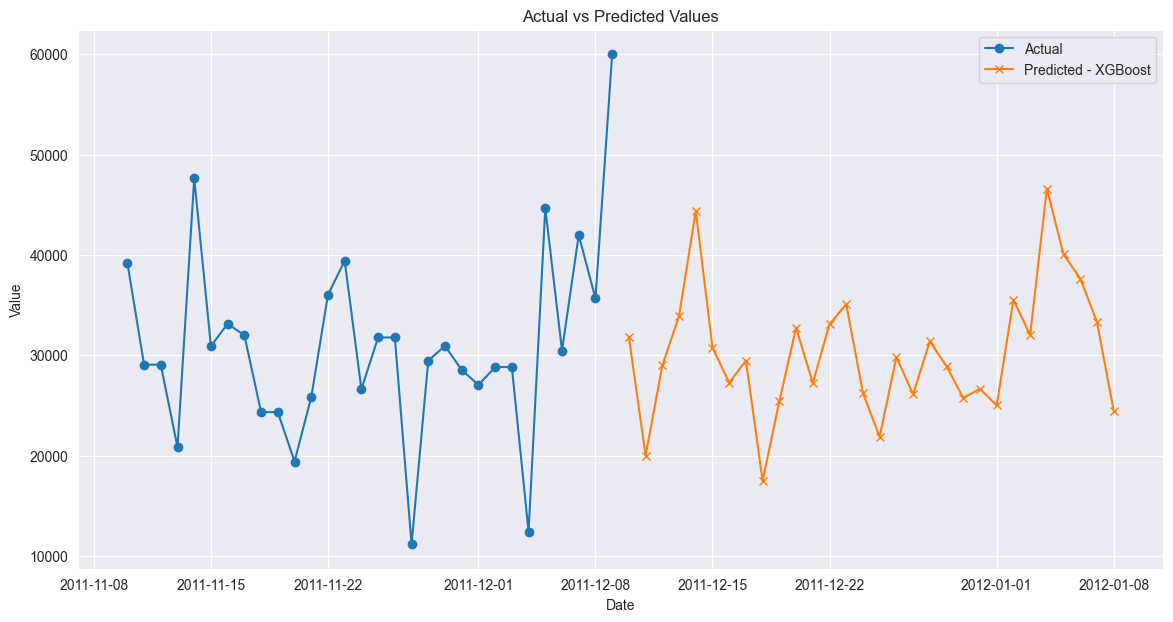

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import holidays

# Make a copy of the dataframe
rml_data = data.copy()

# Ensure 'ds' column is datetime
rml_data['ds'] = pd.to_datetime(rml_data['ds'])

# Define features and target
features = ['month', 'day_of_month', 'is_month_start', 'is_month_end',
            'day_of_year', 'week_of_year', 'day_of_week', 'year',
            'is_weekend', 'is_spring', 'is_summer', 'is_fall', 'is_winter',
            'sin_day', 'cos_day', 'is_public_holiday', 'lag_1', 'lag_2', 
            'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'rolling_mean_7', 
            'rolling_sum_7', 'rolling_std_7', 'rolling_mean_30', 
            'rolling_sum_30', 'rolling_std_30', 'expanding_sum']

target = 'y'

# Split the data into train and test sets
train_df = rml_data[:-30]
test_df = rml_data[-30:]

X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

# Define the models and hyperparameters for tuning
models = {
    'LightGBM': (lgb.LGBMRegressor(), {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'num_leaves': [31, 127]
    }),
    'XGBoost': (XGBRegressor(objective='reg:squarederror'), {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6]
    }),
    'RandomForest': (RandomForestRegressor(), {
        'n_estimators': [100, 200],
        'max_features': ['auto', 'sqrt'],
        'max_depth': [10, 20]
    })
}

# Initialize lists to store the scores
mae_scores = {}
mape_scores = {}

# Train and evaluate each model
for model_name, (model, params) in models.items():
    grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    mae_scores[model_name] = mae
    mape_scores[model_name] = mape
    
    print(f"{model_name} - MAE: {mae:.4f}, MAPE: {mape:.4%}")

# Select the best model based on MAPE
best_model_name = min(mape_scores, key=mape_scores.get)
best_model = models[best_model_name][0]
print(f"\nThe best model is {best_model_name} with a MAPE of {mape_scores[best_model_name]:.4%}")

# Retrain the best model on the entire dataset
best_model.fit(rml_data[features], rml_data[target])

# Predict the next 30 days
future_dates = pd.date_range(start=rml_data['ds'].max() + pd.Timedelta(days=1), periods=30, freq='D')
future_df = pd.DataFrame({
    'ds': future_dates,
    'month': future_dates.month,
    'day_of_month': future_dates.day,
    'is_month_start': future_dates.is_month_start.astype(int),
    'is_month_end': future_dates.is_month_end.astype(int),
    'day_of_year': future_dates.dayofyear,
    'week_of_year': future_dates.isocalendar().week,
    'day_of_week': future_dates.dayofweek + 1,
    'year': future_dates.year,
    'is_weekend': (future_dates.weekday >= 5).astype(int),
    'is_spring': future_dates.month.isin([3, 4, 5]).astype(int),
    'is_summer': future_dates.month.isin([6, 7, 8]).astype(int),
    'is_fall': future_dates.month.isin([9, 10, 11]).astype(int),
    'is_winter': future_dates.month.isin([12, 1, 2]).astype(int),
    'sin_day': np.sin(2 * np.pi * future_dates.dayofweek / 7),
    'cos_day': np.cos(2 * np.pi * future_dates.dayofweek / 7)
})

# Add public holidays for the future dates
uk_holidays = holidays.UK()
future_df['is_public_holiday'] = future_df['ds'].apply(lambda date: 1 if date in uk_holidays else 0)

# Add lag features and rolling statistics for the future_df
for lag in range(1, 8):
    future_df[f'lag_{lag}'] = rml_data[target].shift(lag).iloc[-30:].values

for window in [7, 30]:
    future_df[f'rolling_mean_{window}'] = rml_data[target].rolling(window=window).mean().iloc[-30:].values
    future_df[f'rolling_sum_{window}'] = rml_data[target].rolling(window=window).sum().iloc[-30:].values
    future_df[f'rolling_std_{window}'] = rml_data[target].rolling(window=window).std().iloc[-30:].values

future_df['expanding_sum'] = rml_data[target].expanding().sum().iloc[-30:].values

# Predict future values using the best model
future_predictions = best_model.predict(future_df[features])

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test_df['ds'], test_df['y'], label='Actual', marker='o')
plt.plot(future_df['ds'], future_predictions, label=f'Predicted - {best_model_name}', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3694
[LightGBM] [Info] Number of data points in the train set: 709, number of used features: 29
[LightGBM] [Info] Start training from score 17592.400564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

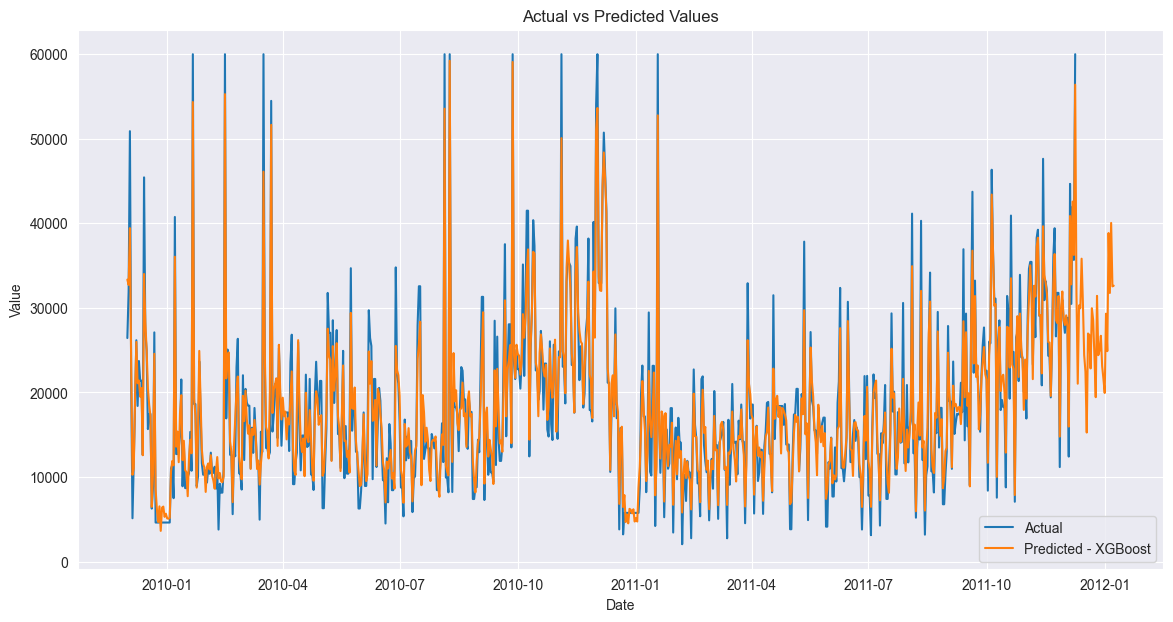

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import holidays

# Make a copy of the dataframe
rml_data = data.copy()

# Ensure 'ds' column is datetime
rml_data['ds'] = pd.to_datetime(rml_data['ds'])

# Define features and target
features = ['month', 'day_of_month', 'is_month_start', 'is_month_end',
            'day_of_year', 'week_of_year', 'day_of_week', 'year',
            'is_weekend', 'is_spring', 'is_summer', 'is_fall', 'is_winter',
            'sin_day', 'cos_day', 'is_public_holiday', 'lag_1', 'lag_2', 
            'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'rolling_mean_7', 
            'rolling_sum_7', 'rolling_std_7', 'rolling_mean_30', 
            'rolling_sum_30', 'rolling_std_30', 'expanding_sum']

target = 'y'

# Split the data into train and test sets
train_df = rml_data[:-30]
test_df = rml_data[-30:]

X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

# Define the models and hyperparameters for tuning
models = {
    'LightGBM': (lgb.LGBMRegressor(), {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'num_leaves': [31, 127]
    }),
    'XGBoost': (XGBRegressor(objective='reg:squarederror'), {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6]
    }),
    'RandomForest': (RandomForestRegressor(), {
        'n_estimators': [100, 200],
        'max_features': ['auto', 'sqrt'],
        'max_depth': [10, 20]
    })
}

# Initialize lists to store the scores and best parameters
mae_scores = {}
mape_scores = {}
best_params_dict = {}

# Train and evaluate each model
for model_name, (model, params) in models.items():
    grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    mae_scores[model_name] = mae
    mape_scores[model_name] = mape
    best_params_dict[model_name] = grid_search.best_params_
    
    print(f"{model_name} - MAE: {mae:.4f}, MAPE: {mape:.4%}")

# Select the best model based on MAPE
best_model_name = min(mape_scores, key=mape_scores.get)
best_model = models[best_model_name][0]
best_params = best_params_dict[best_model_name]

print(f"\nThe best model is {best_model_name} with a MAPE of {mape_scores[best_model_name]:.4%}")
print(f"Best parameters for {best_model_name}: {best_params}")

# Retrain the best model on the entire dataset
best_model.set_params(**best_params)
best_model.fit(rml_data[features], rml_data[target])

# Predict for the entire historical period
historical_predictions = best_model.predict(rml_data[features])

# Predict the next 30 days
future_dates = pd.date_range(start=rml_data['ds'].max() + pd.Timedelta(days=1), periods=30, freq='D')
future_df = pd.DataFrame({
    'ds': future_dates,
    'month': future_dates.month,
    'day_of_month': future_dates.day,
    'is_month_start': future_dates.is_month_start.astype(int),
    'is_month_end': future_dates.is_month_end.astype(int),
    'day_of_year': future_dates.dayofyear,
    'week_of_year': future_dates.isocalendar().week,
    'day_of_week': future_dates.dayofweek + 1,
    'year': future_dates.year,
    'is_weekend': (future_dates.weekday >= 5).astype(int),
    'is_spring': future_dates.month.isin([3, 4, 5]).astype(int),
    'is_summer': future_dates.month.isin([6, 7, 8]).astype(int),
    'is_fall': future_dates.month.isin([9, 10, 11]).astype(int),
    'is_winter': future_dates.month.isin([12, 1, 2]).astype(int),
    'sin_day': np.sin(2 * np.pi * future_dates.dayofweek / 7),
    'cos_day': np.cos(2 * np.pi * future_dates.dayofweek / 7)
})

# Add public holidays for the future dates
uk_holidays = holidays.UK()
future_df['is_public_holiday'] = future_df['ds'].apply(lambda date: 1 if date in uk_holidays else 0)

# Add lag features and rolling statistics for the future_df
for lag in range(1, 8):
    future_df[f'lag_{lag}'] = rml_data[target].shift(lag).iloc[-30:].values

for window in [7, 30]:
    future_df[f'rolling_mean_{window}'] = rml_data[target].rolling(window=window).mean().iloc[-30:].values
    future_df[f'rolling_sum_{window}'] = rml_data[target].rolling(window=window).sum().iloc[-30:].values
    future_df[f'rolling_std_{window}'] = rml_data[target].rolling(window=window).std().iloc[-30:].values

future_df['expanding_sum'] = rml_data[target].expanding().sum().iloc[-30:].values

# Predict future values using the best model
future_predictions = best_model.predict(future_df[features])

# Combine the historical and future data for plotting
combined_df = pd.concat([rml_data, future_df], ignore_index=True)
combined_df['forecast'] = np.nan
combined_df.loc[:len(historical_predictions)-1, 'forecast'] = historical_predictions
combined_df.loc[len(historical_predictions):, 'forecast'] = future_predictions

# Plot actual vs predicted values for the entire period
plt.figure(figsize=(14, 7))
plt.plot(combined_df['ds'], combined_df['y'], label='Actual')
plt.plot(combined_df['ds'], combined_df['forecast'], label=f'Predicted - {best_model_name}')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


# Deep Learning Models

Seed set to 1
Seed set to 1
Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.985     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
10.9 K    Non-trainable params
2.6 M     Total params
10.371    Total estimated model params size (MB)


                  ds         NHITS
unique_id                         
series_1  2011-10-11  28654.951172
series_1  2011-10-12  28996.953125
series_1  2011-10-13  27914.160156
series_1  2011-10-14  21990.765625
series_1  2011-10-15  20636.730469


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 120 K  | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
607 K     Trainable params
0         Non-trainable params
607 K     Total params
2.428     Total estimated model params size (MB)


                  ds        NBEATS
unique_id                         
series_1  2011-10-11  29484.419922
series_1  2011-10-12  29582.451172
series_1  2011-10-13  30686.703125
series_1  2011-10-14  21859.761719
series_1  2011-10-15  21474.042969


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
10.9 K    Non-trainable params
2.6 M     Total params
10.371    Total estimated model params size (MB)


                  ds          LSTM
unique_id                         
series_1  2011-10-11  19644.345703
series_1  2011-10-12  19401.699219
series_1  2011-10-13  18825.123047
series_1  2011-10-14  19091.796875
series_1  2011-10-15  19085.025391


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

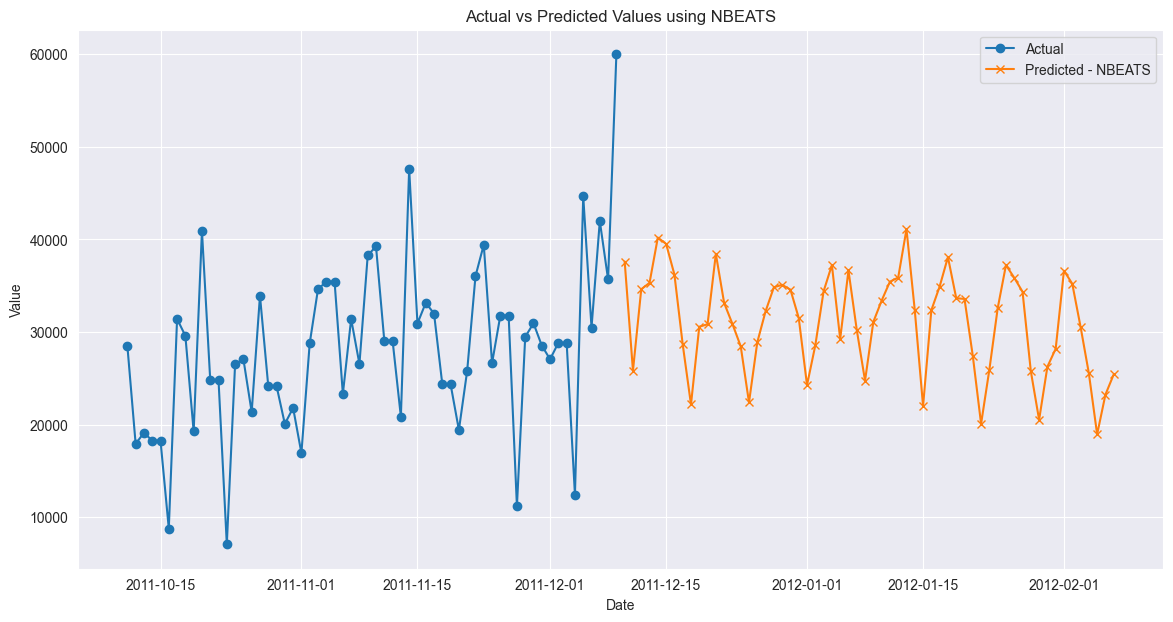

The best model is NBEATS with a MAPE of 0.24762334337143152


In [13]:
import pandas as pd
import numpy as np
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, LSTM
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Make a copy of the dataframe
rml_data = data.copy()

# Ensure 'ds' column is datetime
rml_data['ds'] = pd.to_datetime(rml_data['ds'])

# Add a unique_id column
rml_data['unique_id'] = 'series_1'

# Split the data into train and test sets
train_df = rml_data[:-60]
test_df = rml_data[-60:]

# Define the models and their respective parameters
nhits_params = {
    'h': 60,
    'input_size': 30,
    'max_steps': 50
}

nbeats_params = {
    'h': 60,
    'input_size': 30,
    'max_steps': 50
}

lstm_params = {
    'h': 60,
    'input_size': 30,
    'max_steps': 50
}

# Initialize the models
nhits_model = NHITS(**nhits_params)
nbeats_model = NBEATS(**nbeats_params)
lstm_model = LSTM(**lstm_params)

# Train each model on the training data and evaluate on test data
models = [nhits_model, nbeats_model, lstm_model]
model_names = ['NHITS', 'NBEATS', 'LSTM']
mape_scores = []

for model, name in zip(models, model_names):
    nf = NeuralForecast(models=[model], freq='D')
    nf.fit(df=train_df, id_col='unique_id', time_col='ds', target_col='y')
    forecasts = nf.predict(futr_df=test_df)
    print(forecasts.head())
    mape = mean_absolute_percentage_error(test_df['y'], forecasts[name])
    mape_scores.append((name, mape))

# Select the best model based on MAPE
best_model_name, best_mape = min(mape_scores, key=lambda x: x[1])
best_model = None

if best_model_name == 'NHITS':
    best_model = NHITS(**nhits_params)
elif best_model_name == 'NBEATS':
    best_model = NBEATS(**nbeats_params)
elif best_model_name == 'LSTM':
    best_model = LSTM(**lstm_params)

# Train the best model on the entire dataset
nf_best_model = NeuralForecast(models=[best_model], freq='D')
nf_best_model.fit(df=rml_data, id_col='unique_id', time_col='ds', target_col='y')

# Predict the next 60 days with the best model
future_dates = pd.date_range(rml_data['ds'].max() + pd.Timedelta(days=1), periods=60, freq='D')
future_df = pd.DataFrame({'ds': future_dates})
future_df['unique_id'] = 'series_1'

final_forecasts = nf_best_model.predict(futr_df=future_df)

# Plot actual vs predicted values for the best model
plt.figure(figsize=(14, 7))

# Plot the test data
plt.plot(test_df['ds'], test_df['y'], label='Actual', marker='o')

# Plot the forecasts
plt.plot(
    future_dates,
    final_forecasts[best_model_name][:60],  # Ensure we take only 60 predictions
    label=f'Predicted - {best_model_name}',
    marker='x',
)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'Actual vs Predicted Values using {best_model_name}')
plt.legend()
plt.grid(True)
plt.show()

print(f"The best model is {best_model_name} with a MAPE of {best_mape}")


### Reduce forecast horizon to 30 days

Seed set to 1
Seed set to 1
Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.876     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
3.7 K     Non-trainable params
2.5 M     Total params
10.034    Total estimated model params size (MB)


                  ds         NHITS
unique_id                         
series_1  2011-11-10  28311.250000
series_1  2011-11-11  24709.126953
series_1  2011-11-12  23716.328125
series_1  2011-11-13  21084.410156
series_1  2011-11-14  22249.330078


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)


                  ds        NBEATS
unique_id                         
series_1  2011-11-10  34440.773438
series_1  2011-11-11  25806.494141
series_1  2011-11-12  24580.664062
series_1  2011-11-13  16437.824219
series_1  2011-11-14  26988.980469


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
3.7 K     Non-trainable params
2.5 M     Total params
10.034    Total estimated model params size (MB)


                  ds          LSTM
unique_id                         
series_1  2011-11-10  18968.152344
series_1  2011-11-11  18164.500000
series_1  2011-11-12  18409.970703
series_1  2011-11-13  19364.675781
series_1  2011-11-14  19468.369141


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

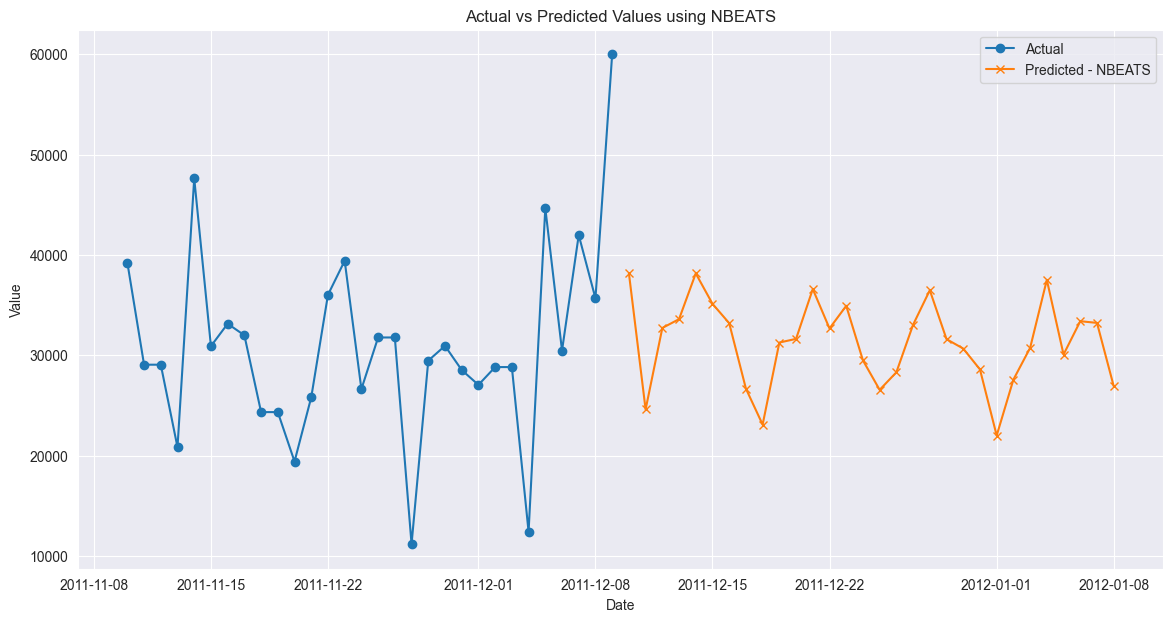

The best model is NBEATS with a MAPE of 0.2040052052785068


In [14]:
import pandas as pd
import numpy as np
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, LSTM
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Make a copy of the dataframe
rml_data = data.copy()

# Ensure 'ds' column is datetime
rml_data['ds'] = pd.to_datetime(rml_data['ds'])

# Add a unique_id column
rml_data['unique_id'] = 'series_1'

# Split the data into train and test sets
train_df = rml_data[:-30]
test_df = rml_data[-30:]

# Define the models and their respective parameters
nhits_params = {
    'h': 30,
    'input_size': 30,
    'max_steps': 50
}

nbeats_params = {
    'h': 30,
    'input_size': 30,
    'max_steps': 50
}

lstm_params = {
    'h': 30,
    'input_size': 30,
    'max_steps': 50
}

# Initialize the models
nhits_model = NHITS(**nhits_params)
nbeats_model = NBEATS(**nbeats_params)
lstm_model = LSTM(**lstm_params)

# Train each model on the training data and evaluate on test data
models = [nhits_model, nbeats_model, lstm_model]
model_names = ['NHITS', 'NBEATS', 'LSTM']
mape_scores = []

for model, name in zip(models, model_names):
    nf = NeuralForecast(models=[model], freq='D')
    nf.fit(df=train_df, id_col='unique_id', time_col='ds', target_col='y')
    forecasts = nf.predict(futr_df=test_df)
    print(forecasts.head())
    mape = mean_absolute_percentage_error(test_df['y'], forecasts[name])
    mape_scores.append((name, mape))

# Select the best model based on MAPE
best_model_name, best_mape = min(mape_scores, key=lambda x: x[1])
best_model = None

if best_model_name == 'NHITS':
    best_model = NHITS(**nhits_params)
elif best_model_name == 'NBEATS':
    best_model = NBEATS(**nbeats_params)
elif best_model_name == 'LSTM':
    best_model = LSTM(**lstm_params)

# Train the best model on the entire dataset
nf_best_model = NeuralForecast(models=[best_model], freq='D')
nf_best_model.fit(df=rml_data, id_col='unique_id', time_col='ds', target_col='y')

# Predict the next 30 days with the best model
future_dates = pd.date_range(rml_data['ds'].max() + pd.Timedelta(days=1), periods=30, freq='D')
future_df = pd.DataFrame({'ds': future_dates})
future_df['unique_id'] = 'series_1'

final_forecasts = nf_best_model.predict(futr_df=future_df)

# Plot actual vs predicted values for the best model
plt.figure(figsize=(14, 7))

# Plot the test data
plt.plot(test_df['ds'], test_df['y'], label='Actual', marker='o')

# Plot the forecasts
plt.plot(
    future_dates,
    final_forecasts[best_model_name][:30],  # Ensure we take only 30 predictions
    label=f'Predicted - {best_model_name}',
    marker='x',
)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'Actual vs Predicted Values using {best_model_name}')
plt.legend()
plt.grid(True)
plt.show()

print(f"The best model is {best_model_name} with a MAPE of {best_mape}")


In [12]:
data.drop(columns=['date'],inplace=True)
data.head()

,quantity,month,day_of_month,is_month_start,is_month_end,day_of_year,week_of_year,day_of_week,year,is_weekend,...,rolling_mean_7,rolling_sum_7,rolling_std_7,rolling_mean_30,rolling_sum_30,rolling_std_30,expanding_sum,quantity_winsorized,ds,y
date,,,,,,,,,,,,,,,,,,,,,
2009-12-01,26434.0,12,1,1,0,335,49,2,2009,1,...,23710.571429,165974.0,14932.597372,17233.666667,517010.0,12220.541413,26434.0,26434.0,2009-12-01,26434.0
2009-12-02,31938.0,12,2,0,0,336,49,3,2009,2,...,23710.571429,165974.0,14932.597372,17233.666667,517010.0,12220.541413,58372.0,31938.0,2009-12-02,31938.0
2009-12-03,50898.0,12,3,0,0,337,49,4,2009,3,...,23710.571429,165974.0,14932.597372,17233.666667,517010.0,12220.541413,109270.0,50898.0,2009-12-03,50898.0
2009-12-04,21405.0,12,4,0,0,338,49,5,2009,4,...,23710.571429,165974.0,14932.597372,17233.666667,517010.0,12220.541413,130675.0,21405.0,2009-12-04,21405.0
2009-12-05,5119.0,12,5,0,0,339,49,6,2009,5,...,23710.571429,165974.0,14932.597372,17233.666667,517010.0,12220.541413,135794.0,5119.0,2009-12-05,5119.0


### Fine tuning

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.876     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.876     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.876     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=150` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.184    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.184    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.184    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=150` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.491    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.491    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.491    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=150` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
3.7 K     Non-trainable params
2.5 M     Total params
10.034    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
3.7 K     Non-trainable params
2.5 M     Total params
10.034    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
3.7 K     Non-trainable params
2.5 M     Total params
10.034    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=150` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
5.5 K     Non-trainable params
2.6 M     Total params
10.287    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
5.5 K     Non-trainable params
2.6 M     Total params
10.287    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
5.5 K     Non-trainable params
2.6 M     Total params
10.287    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=150` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
7.3 K     Non-trainable params
2.6 M     Total params
10.541    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
7.3 K     Non-trainable params
2.6 M     Total params
10.541    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
7.3 K     Non-trainable params
2.6 M     Total params
10.541    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=150` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=150` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=150` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=150` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
7.3 K     Non-trainable params
2.6 M     Total params
10.541    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

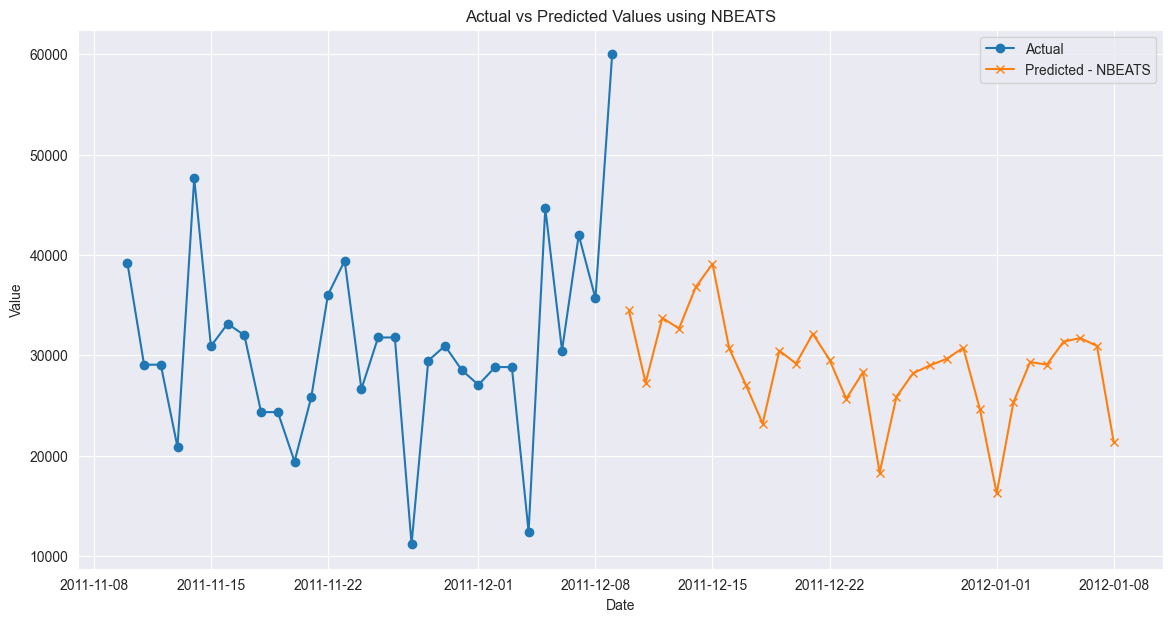

The best model is NBEATS with a MAPE of 0.18373028713500753
Best parameters: {'h': 30, 'input_size': 90, 'max_steps': 50}


In [15]:
import pandas as pd
import numpy as np
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, LSTM
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt

# Make a copy of the dataframe
rml_data = data.copy()

# Ensure 'ds' column is datetime
rml_data['ds'] = pd.to_datetime(rml_data['ds'])

# Add a unique_id column
rml_data['unique_id'] = 'series_1'

# Split the data into train and test sets
train_df = rml_data[:-30]
test_df = rml_data[-30:]

# Define the parameter grids for each model
nhits_param_grid = {
    'h': [30],
    'input_size': [30, 60, 90],
    'max_steps': [50, 100, 150]
}

nbeats_param_grid = {
    'h': [30],
    'input_size': [30, 60, 90],
    'max_steps': [50, 100, 150]
}

lstm_param_grid = {
    'h': [30],
    'input_size': [30, 60, 90],
    'max_steps': [50, 100, 150]
}

# Initialize the parameter grids
nhits_params_list = list(ParameterGrid(nhits_param_grid))
nbeats_params_list = list(ParameterGrid(nbeats_param_grid))
lstm_params_list = list(ParameterGrid(lstm_param_grid))

# Function to train and evaluate a model with given parameters
def train_evaluate_model(model_class, param_list, train_df, test_df, model_name):
    best_params = None
    best_mape = float('inf')
    best_forecasts = None

    for params in param_list:
        model = model_class(**params)
        nf = NeuralForecast(models=[model], freq='D')
        nf.fit(df=train_df, id_col='unique_id', time_col='ds', target_col='y')
        forecasts = nf.predict(futr_df=test_df)
        
        mape = mean_absolute_percentage_error(test_df['y'], forecasts[model_name])
        
        if mape < best_mape:
            best_mape = mape
            best_params = params
            best_forecasts = forecasts
    
    return best_params, best_mape, best_forecasts

# Fine-tune and evaluate each model
nhits_best_params, nhits_best_mape, nhits_best_forecasts = train_evaluate_model(
    NHITS, nhits_params_list, train_df, test_df, 'NHITS'
)

nbeats_best_params, nbeats_best_mape, nbeats_best_forecasts = train_evaluate_model(
    NBEATS, nbeats_params_list, train_df, test_df, 'NBEATS'
)

lstm_best_params, lstm_best_mape, lstm_best_forecasts = train_evaluate_model(
    LSTM, lstm_params_list, train_df, test_df, 'LSTM'
)

# Store the best models and their MAPE scores
best_models = [
    ('NHITS', nhits_best_mape, NHITS, nhits_best_params, nhits_best_forecasts),
    ('NBEATS', nbeats_best_mape, NBEATS, nbeats_best_params, nbeats_best_forecasts),
    ('LSTM', lstm_best_mape, LSTM, lstm_best_params, lstm_best_forecasts)
]

# Select the best model based on MAPE
best_model_name, best_mape, best_model_class, best_model_params, best_forecasts = min(
    best_models, key=lambda x: x[1]
)

# Train the best model on the entire dataset with the best parameters
best_model = best_model_class(**best_model_params)
nf_best_model = NeuralForecast(models=[best_model], freq='D')
nf_best_model.fit(df=rml_data, id_col='unique_id', time_col='ds', target_col='y')

# Predict the next 30 days with the best model
future_dates = pd.date_range(rml_data['ds'].max() + pd.Timedelta(days=1), periods=30, freq='D')
future_df = pd.DataFrame({'ds': future_dates})
future_df['unique_id'] = 'series_1'

final_forecasts = nf_best_model.predict(futr_df=future_df)

# Plot actual vs predicted values for the best model
plt.figure(figsize=(14, 7))

# Plot the test data
plt.plot(test_df['ds'], test_df['y'], label='Actual', marker='o')

# Plot the forecasts
plt.plot(
    future_dates,
    final_forecasts[best_model_name][:30],  # Ensure we take only 30 predictions
    label=f'Predicted - {best_model_name}',
    marker='x',
)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'Actual vs Predicted Values using {best_model_name}')
plt.legend()
plt.grid(True)
plt.show()

print(f"The best model is {best_model_name} with a MAPE of {best_mape}")
print(f"Best parameters: {best_model_params}")


# Prophet

01:49:55 - cmdstanpy - INFO - Chain [1] start processing
01:49:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:49:59 - cmdstanpy - INFO - Chain [1] start processing
01:50:00 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0  6 days  47357331.87  6881.67  6066.40  0.41   0.36   0.32      0.83
1  7 days  53757525.41  7331.95  7001.80  0.44   0.36   0.35      0.83
2  8 days  44264555.34  6653.16  6160.39  0.38   0.25   0.31      0.83
3  9 days  30954723.23  5563.70  5331.80  0.33   0.25   0.28      1.00
4 10 days  52833553.49  7268.67  6611.39  0.34   0.26   0.30      0.83
MAPE: 0.246


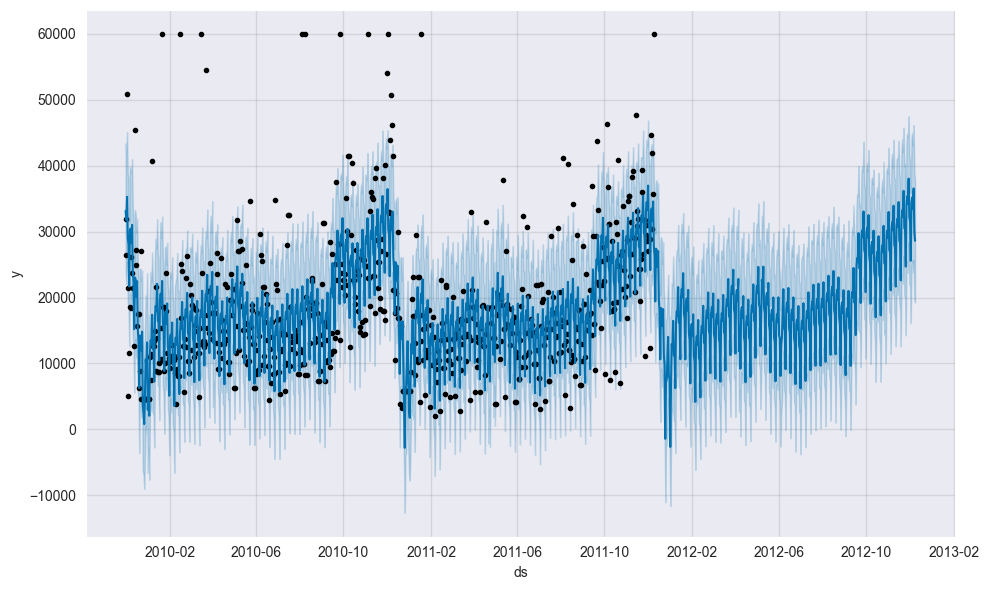

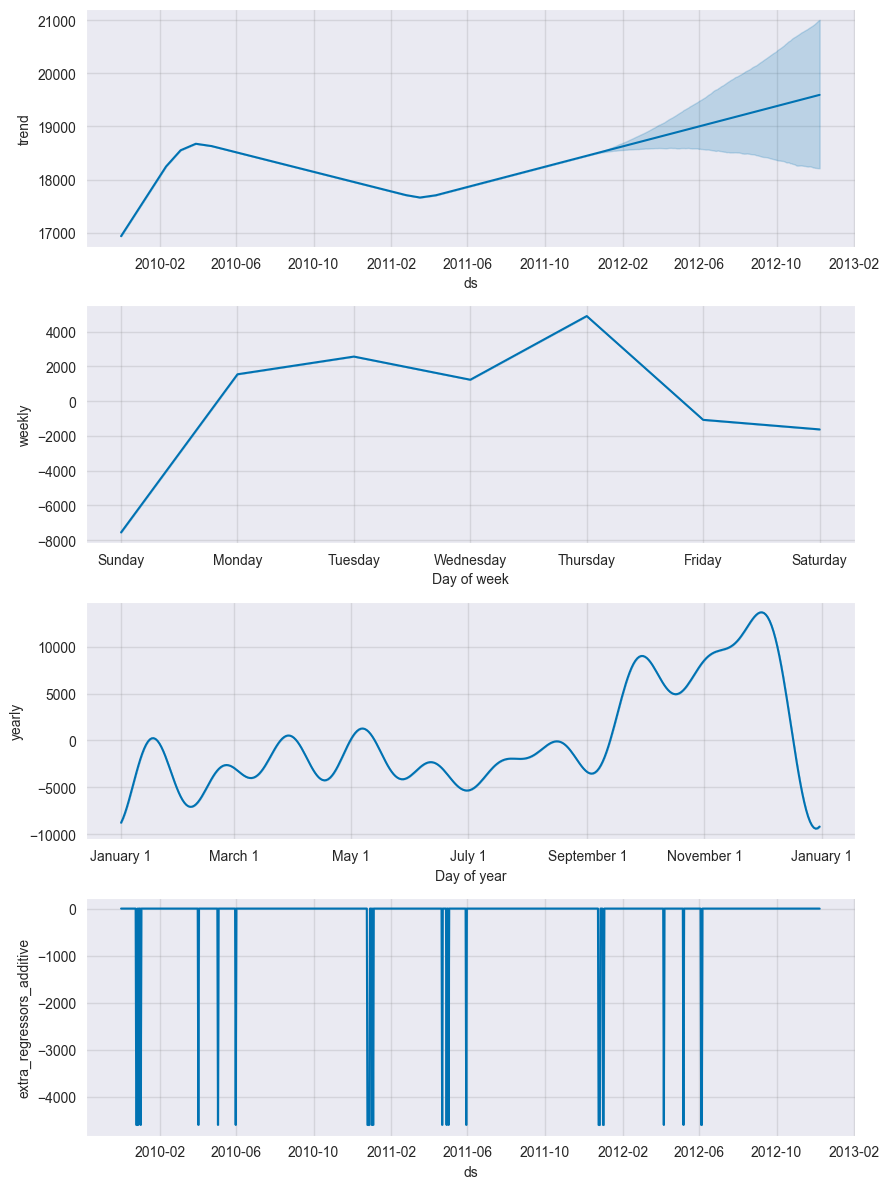

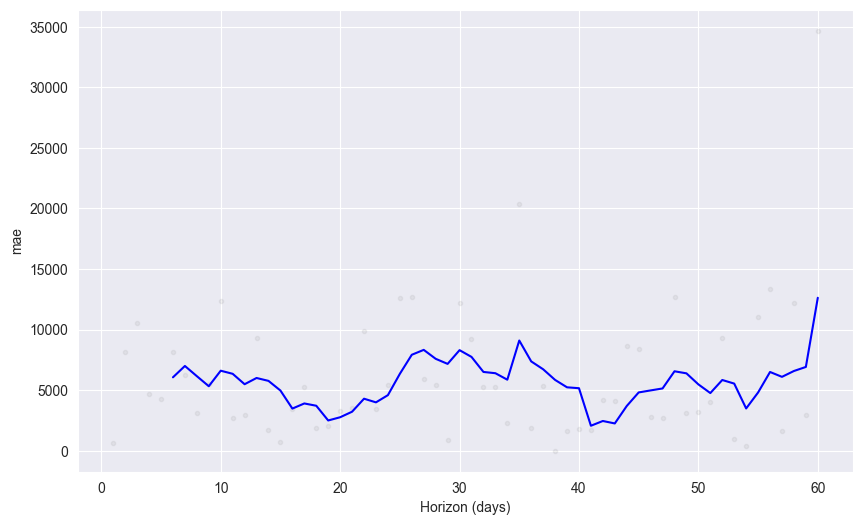

In [18]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import holidays
from sklearn.metrics import mean_absolute_percentage_error

# 1. Prepare Data
# data = df.copy()
# data["ds"] = df.index
# data["y"] = df["quantity_winsorized"]
# data['ds'] = pd.to_datetime(data['ds'])

# Add is_public_holiday column
holiday = holidays.CountryHoliday('UK')
data['is_public_holiday'] = data['ds'].apply(
    lambda date: 1 if date in holiday else 0
)

# Define specific hyperparameters (based on previous knowledge or initial testing)
params = {
    'changepoint_prior_scale': 0.1,
    'seasonality_prior_scale': 1.0,
    'holidays_prior_scale': 1.0,
    'seasonality_mode': 'additive'
}

# Train the model with the defined hyperparameters
model = Prophet(**params)
model.add_regressor('is_public_holiday')
model.fit(data)

# Forecast future values
future = model.make_future_dataframe(periods=365)
future['is_public_holiday'] = future['ds'].apply(
    lambda date: 1 if date in holiday else 0
)

forecast = model.predict(future)

# Visualize Results
model.plot(forecast)
model.plot_components(forecast)

# Evaluate Accuracy
df_cv = cross_validation(model, initial='547 days', period='180 days', horizon='60 days')
df_p = performance_metrics(df_cv)
print(df_p.head().round(2))

fig = plot_cross_validation_metric(df_cv, metric='mae')

# Calculate MAPE using yhat and y
mape = mean_absolute_percentage_error(df_cv['y'], df_cv['yhat'])
print(f"MAPE: {round(mape, 3)}")


01:49:17 - cmdstanpy - INFO - Chain [1] start processing
01:49:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:49:19 - cmdstanpy - INFO - Chain [1] start processing
01:49:19 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse      rmse      mae  mape  mdape  smape  coverage
0  3 days  2.468161e+07   4968.06  4627.40  0.14   0.12   0.15      1.00
1  4 days  7.632877e+06   2762.77  2458.33  0.09   0.11   0.09      1.00
2  5 days  1.202225e+08  10964.60  7583.06  0.18   0.12   0.21      0.67
3  6 days  1.164492e+08  10791.16  6614.63  0.15   0.03   0.18      0.67
4  7 days  1.216958e+08  11031.58  7730.70  0.18   0.12   0.21      0.67
MAPE: 0.217


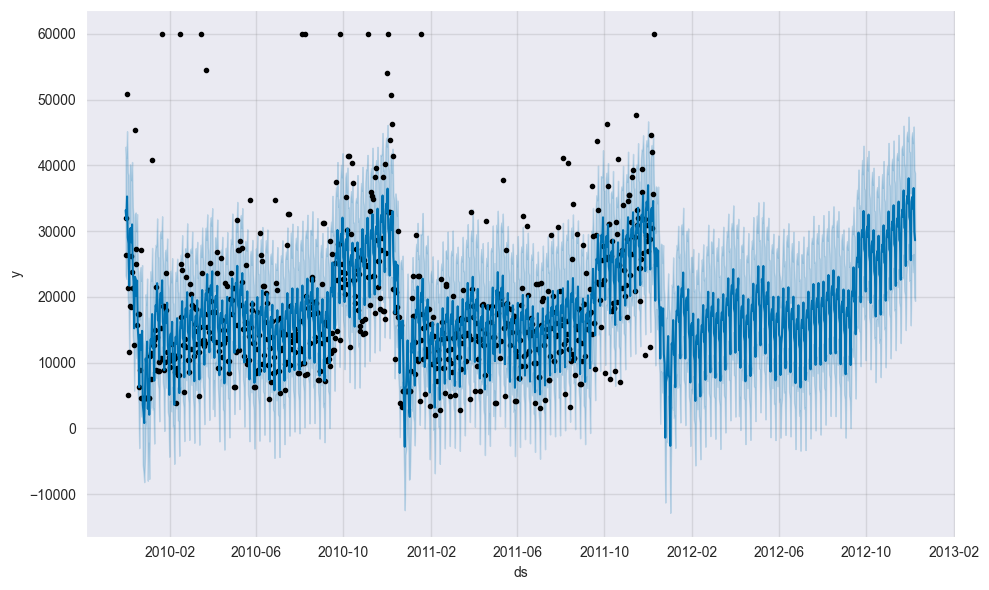

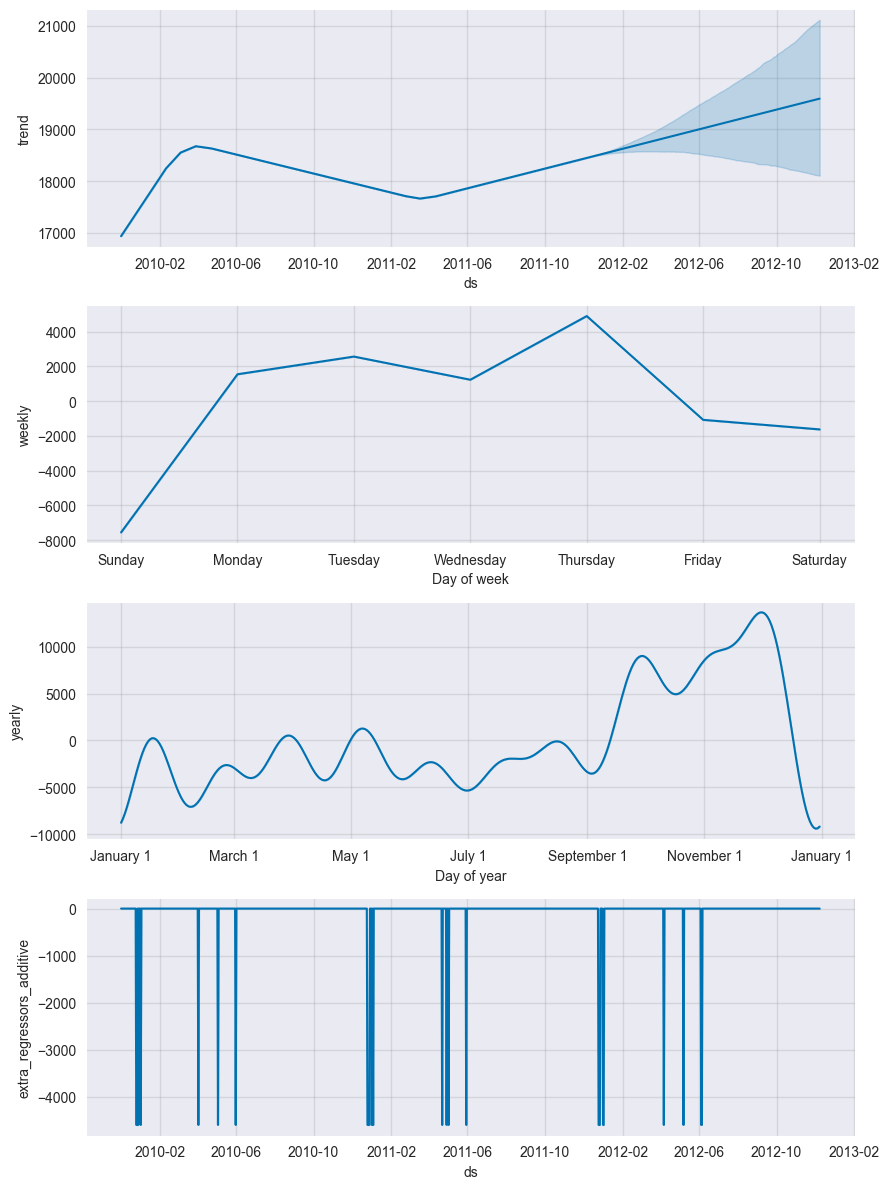

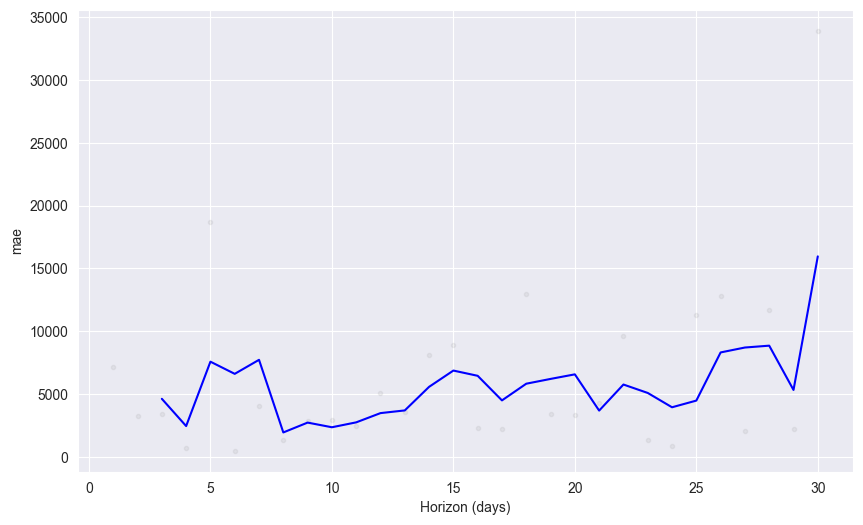

In [17]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import holidays
from sklearn.metrics import mean_absolute_percentage_error



# Add is_public_holiday column
holiday = holidays.CountryHoliday('UK')
data['is_public_holiday'] = data['ds'].apply(
    lambda date: 1 if date in holiday else 0
)

# Define specific hyperparameters (based on previous knowledge or initial testing)
params = {
    'changepoint_prior_scale': 0.1,
    'seasonality_prior_scale': 1.0,
    'holidays_prior_scale': 1.0,
    'seasonality_mode': 'additive'
}

# Train the model with the defined hyperparameters
model = Prophet(**params)
model.add_regressor('is_public_holiday')
model.fit(data)

# Forecast future values
future = model.make_future_dataframe(periods=365)
future['is_public_holiday'] = future['ds'].apply(
    lambda date: 1 if date in holiday else 0
)

forecast = model.predict(future)

# Visualize Results
model.plot(forecast)
model.plot_components(forecast)

# Evaluate Accuracy
df_cv = cross_validation(model, initial='547 days', period='180 days', horizon='30 days')
df_p = performance_metrics(df_cv)
print(df_p.head().round(2))

fig = plot_cross_validation_metric(df_cv, metric='mae')

# Calculate MAPE using yhat and y
mape = mean_absolute_percentage_error(df_cv['y'], df_cv['yhat'])
print(f"MAPE: {round(mape, 3)}")


01:44:15 - cmdstanpy - INFO - Chain [1] start processing
01:44:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:15 - cmdstanpy - INFO - Chain [1] start processing
01:44:15 - cmdstanpy - INFO - Chain [1] done processing
01:44:16 - cmdstanpy - INFO - Chain [1] start processing
01:44:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:17 - cmdstanpy - INFO - Chain [1] start processing
01:44:17 - cmdstanpy - INFO - Chain [1] done processing
01:44:17 - cmdstanpy - INFO - Chain [1] start processing
01:44:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:20 - cmdstanpy - INFO - Chain [1] start processing
01:44:20 - cmdstanpy - INFO - Chain [1] done processing
01:44:22 - cmdstanpy - INFO - Chain [1] start processing
01:44:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:22 - cmdstanpy - INFO - Chain [1] start processing
01:44:22 - cmdstanpy - INFO - Chain [1] done processing
01:44:23 - cmdstanpy - INFO - Chain [1] start processing
01:44:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:24 - cmdstanpy - INFO - Chain [1] start processing
01:44:24 - cmdstanpy - INFO - Chain [1] done processing
01:44:25 - cmdstanpy - INFO - Chain [1] start processing
01:44:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:25 - cmdstanpy - INFO - Chain [1] start processing
01:44:25 - cmdstanpy - INFO - Chain [1] done processing
01:44:26 - cmdstanpy - INFO - Chain [1] start processing
01:44:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:27 - cmdstanpy - INFO - Chain [1] start processing
01:44:27 - cmdstanpy - INFO - Chain [1] done processing
01:44:27 - cmdstanpy - INFO - Chain [1] start processing
01:44:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:29 - cmdstanpy - INFO - Chain [1] start processing
01:44:29 - cmdstanpy - INFO - Chain [1] done processing
01:44:30 - cmdstanpy - INFO - Chain [1] start processing
01:44:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:30 - cmdstanpy - INFO - Chain [1] start processing
01:44:31 - cmdstanpy - INFO - Chain [1] done processing
01:44:31 - cmdstanpy - INFO - Chain [1] start processing
01:44:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:32 - cmdstanpy - INFO - Chain [1] start processing
01:44:32 - cmdstanpy - INFO - Chain [1] done processing
01:44:32 - cmdstanpy - INFO - Chain [1] start processing
01:44:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:33 - cmdstanpy - INFO - Chain [1] start processing
01:44:33 - cmdstanpy - INFO - Chain [1] done processing
01:44:34 - cmdstanpy - INFO - Chain [1] start processing
01:44:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:34 - cmdstanpy - INFO - Chain [1] start processing
01:44:34 - cmdstanpy - INFO - Chain [1] done processing
01:44:35 - cmdstanpy - INFO - Chain [1] start processing
01:44:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:35 - cmdstanpy - INFO - Chain [1] start processing
01:44:36 - cmdstanpy - INFO - Chain [1] done processing
01:44:36 - cmdstanpy - INFO - Chain [1] start processing
01:44:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:37 - cmdstanpy - INFO - Chain [1] start processing
01:44:37 - cmdstanpy - INFO - Chain [1] done processing
01:44:37 - cmdstanpy - INFO - Chain [1] start processing
01:44:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:38 - cmdstanpy - INFO - Chain [1] start processing
01:44:38 - cmdstanpy - INFO - Chain [1] done processing
01:44:38 - cmdstanpy - INFO - Chain [1] start processing
01:44:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:39 - cmdstanpy - INFO - Chain [1] start processing
01:44:39 - cmdstanpy - INFO - Chain [1] done processing
01:44:39 - cmdstanpy - INFO - Chain [1] start processing
01:44:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:40 - cmdstanpy - INFO - Chain [1] start processing
01:44:40 - cmdstanpy - INFO - Chain [1] done processing
01:44:41 - cmdstanpy - INFO - Chain [1] start processing
01:44:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:41 - cmdstanpy - INFO - Chain [1] start processing
01:44:41 - cmdstanpy - INFO - Chain [1] done processing
01:44:42 - cmdstanpy - INFO - Chain [1] start processing
01:44:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:42 - cmdstanpy - INFO - Chain [1] start processing
01:44:42 - cmdstanpy - INFO - Chain [1] done processing
01:44:43 - cmdstanpy - INFO - Chain [1] start processing
01:44:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:43 - cmdstanpy - INFO - Chain [1] start processing
01:44:43 - cmdstanpy - INFO - Chain [1] done processing
01:44:44 - cmdstanpy - INFO - Chain [1] start processing
01:44:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:44 - cmdstanpy - INFO - Chain [1] start processing
01:44:45 - cmdstanpy - INFO - Chain [1] done processing
01:44:45 - cmdstanpy - INFO - Chain [1] start processing
01:44:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:46 - cmdstanpy - INFO - Chain [1] start processing
01:44:46 - cmdstanpy - INFO - Chain [1] done processing
01:44:46 - cmdstanpy - INFO - Chain [1] start processing
01:44:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:47 - cmdstanpy - INFO - Chain [1] start processing
01:44:47 - cmdstanpy - INFO - Chain [1] done processing
01:44:47 - cmdstanpy - INFO - Chain [1] start processing
01:44:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:48 - cmdstanpy - INFO - Chain [1] start processing
01:44:48 - cmdstanpy - INFO - Chain [1] done processing
01:44:49 - cmdstanpy - INFO - Chain [1] start processing
01:44:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:49 - cmdstanpy - INFO - Chain [1] start processing
01:44:49 - cmdstanpy - INFO - Chain [1] done processing
01:44:50 - cmdstanpy - INFO - Chain [1] start processing
01:44:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:50 - cmdstanpy - INFO - Chain [1] start processing
01:44:50 - cmdstanpy - INFO - Chain [1] done processing
01:44:51 - cmdstanpy - INFO - Chain [1] start processing
01:44:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:51 - cmdstanpy - INFO - Chain [1] start processing
01:44:52 - cmdstanpy - INFO - Chain [1] done processing
01:44:52 - cmdstanpy - INFO - Chain [1] start processing
01:44:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:53 - cmdstanpy - INFO - Chain [1] start processing
01:44:53 - cmdstanpy - INFO - Chain [1] done processing
01:44:53 - cmdstanpy - INFO - Chain [1] start processing
01:44:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:54 - cmdstanpy - INFO - Chain [1] start processing
01:44:54 - cmdstanpy - INFO - Chain [1] done processing
01:44:54 - cmdstanpy - INFO - Chain [1] start processing
01:44:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:55 - cmdstanpy - INFO - Chain [1] start processing
01:44:55 - cmdstanpy - INFO - Chain [1] done processing
01:44:55 - cmdstanpy - INFO - Chain [1] start processing
01:44:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:56 - cmdstanpy - INFO - Chain [1] start processing
01:44:56 - cmdstanpy - INFO - Chain [1] done processing
01:44:57 - cmdstanpy - INFO - Chain [1] start processing
01:44:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:57 - cmdstanpy - INFO - Chain [1] start processing
01:44:57 - cmdstanpy - INFO - Chain [1] done processing
01:44:58 - cmdstanpy - INFO - Chain [1] start processing
01:44:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:58 - cmdstanpy - INFO - Chain [1] start processing
01:44:58 - cmdstanpy - INFO - Chain [1] done processing
01:44:59 - cmdstanpy - INFO - Chain [1] start processing
01:44:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:44:59 - cmdstanpy - INFO - Chain [1] start processing
01:45:00 - cmdstanpy - INFO - Chain [1] done processing
01:45:00 - cmdstanpy - INFO - Chain [1] start processing
01:45:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:45:01 - cmdstanpy - INFO - Chain [1] start processing
01:45:01 - cmdstanpy - INFO - Chain [1] done processing
01:45:01 - cmdstanpy - INFO - Chain [1] start processing
01:45:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:45:02 - cmdstanpy - INFO - Chain [1] start processing
01:45:02 - cmdstanpy - INFO - Chain [1] done processing
01:45:02 - cmdstanpy - INFO - Chain [1] start processing
01:45:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:45:03 - cmdstanpy - INFO - Chain [1] start processing
01:45:03 - cmdstanpy - INFO - Chain [1] done processing
01:45:04 - cmdstanpy - INFO - Chain [1] start processing
01:45:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:45:04 - cmdstanpy - INFO - Chain [1] start processing
01:45:04 - cmdstanpy - INFO - Chain [1] done processing
01:45:05 - cmdstanpy - INFO - Chain [1] start processing
01:45:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:45:05 - cmdstanpy - INFO - Chain [1] start processing
01:45:06 - cmdstanpy - INFO - Chain [1] done processing
01:45:06 - cmdstanpy - INFO - Chain [1] start processing
01:45:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:45:07 - cmdstanpy - INFO - Chain [1] start processing
01:45:07 - cmdstanpy - INFO - Chain [1] done processing
01:45:08 - cmdstanpy - INFO - Chain [1] start processing
01:45:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:45:09 - cmdstanpy - INFO - Chain [1] start processing
01:45:09 - cmdstanpy - INFO - Chain [1] done processing
01:45:09 - cmdstanpy - INFO - Chain [1] start processing
01:45:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:45:10 - cmdstanpy - INFO - Chain [1] start processing
01:45:10 - cmdstanpy - INFO - Chain [1] done processing
01:45:11 - cmdstanpy - INFO - Chain [1] start processing
01:45:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:45:11 - cmdstanpy - INFO - Chain [1] start processing
01:45:11 - cmdstanpy - INFO - Chain [1] done processing
01:45:12 - cmdstanpy - INFO - Chain [1] start processing
01:45:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:45:12 - cmdstanpy - INFO - Chain [1] start processing
01:45:13 - cmdstanpy - INFO - Chain [1] done processing
01:45:13 - cmdstanpy - INFO - Chain [1] start processing
01:45:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:45:13 - cmdstanpy - INFO - Chain [1] start processing
01:45:14 - cmdstanpy - INFO - Chain [1] done processing
01:45:14 - cmdstanpy - INFO - Chain [1] start processing
01:45:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:45:15 - cmdstanpy - INFO - Chain [1] start processing
01:45:15 - cmdstanpy - INFO - Chain [1] done processing
01:45:15 - cmdstanpy - INFO - Chain [1] start processing
01:45:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:45:16 - cmdstanpy - INFO - Chain [1] start processing
01:45:16 - cmdstanpy - INFO - Chain [1] done processing
01:45:17 - cmdstanpy - INFO - Chain [1] start processing
01:45:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:45:17 - cmdstanpy - INFO - Chain [1] start processing
01:45:18 - cmdstanpy - INFO - Chain [1] done processing
01:45:18 - cmdstanpy - INFO - Chain [1] start processing
01:45:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:45:19 - cmdstanpy - INFO - Chain [1] start processing
01:45:19 - cmdstanpy - INFO - Chain [1] done processing
01:45:19 - cmdstanpy - INFO - Chain [1] start processing
01:45:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:45:20 - cmdstanpy - INFO - Chain [1] start processing
01:45:20 - cmdstanpy - INFO - Chain [1] done processing
01:45:20 - cmdstanpy - INFO - Chain [1] start processing
01:45:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:45:21 - cmdstanpy - INFO - Chain [1] start processing
01:45:22 - cmdstanpy - INFO - Chain [1] done processing
01:45:22 - cmdstanpy - INFO - Chain [1] start processing
01:45:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:45:23 - cmdstanpy - INFO - Chain [1] start processing
01:45:23 - cmdstanpy - INFO - Chain [1] done processing
01:45:23 - cmdstanpy - INFO - Chain [1] start processing
01:45:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:45:24 - cmdstanpy - INFO - Chain [1] start processing
01:45:24 - cmdstanpy - INFO - Chain [1] done processing
01:45:24 - cmdstanpy - INFO - Chain [1] start processing
01:45:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:45:25 - cmdstanpy - INFO - Chain [1] start processing
01:45:25 - cmdstanpy - INFO - Chain [1] done processing


Best Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Best MAPE: 0.21


01:45:25 - cmdstanpy - INFO - Chain [1] start processing
01:45:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

01:45:27 - cmdstanpy - INFO - Chain [1] start processing
01:45:27 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse      rmse      mae  mape  mdape  smape  coverage
0  3 days  2.947427e+07   5429.02  5117.75  0.15   0.13   0.17      1.00
1  4 days  1.030618e+07   3210.32  2960.90  0.11   0.13   0.11      1.00
2  5 days  1.286424e+08  11342.06  8110.27  0.20   0.13   0.24      0.67
3  6 days  1.239651e+08  11133.96  7179.03  0.17   0.06   0.20      0.67
4  7 days  1.307609e+08  11435.07  8334.31  0.19   0.14   0.23      0.67
MAPE: 0.208


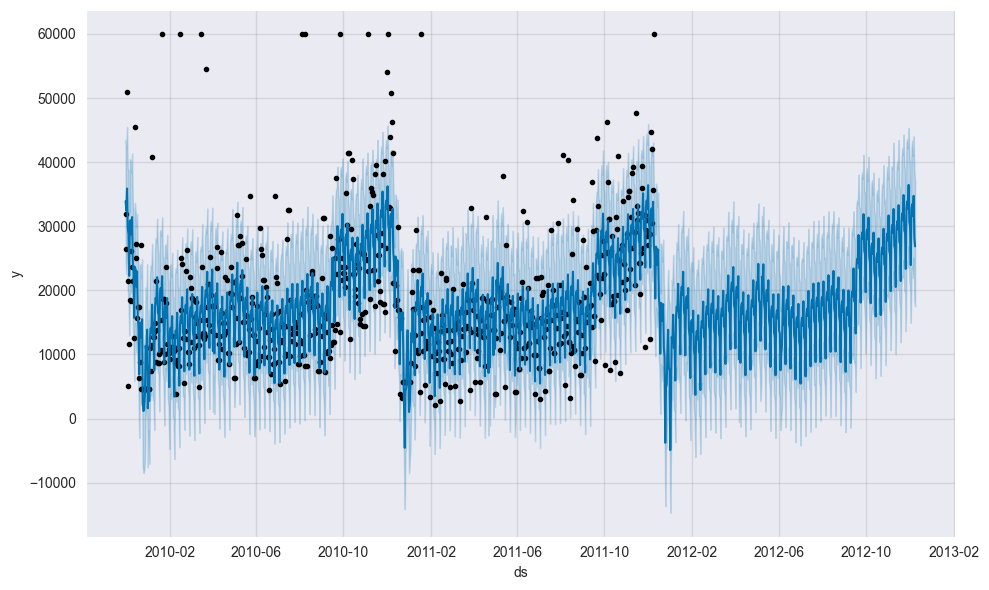

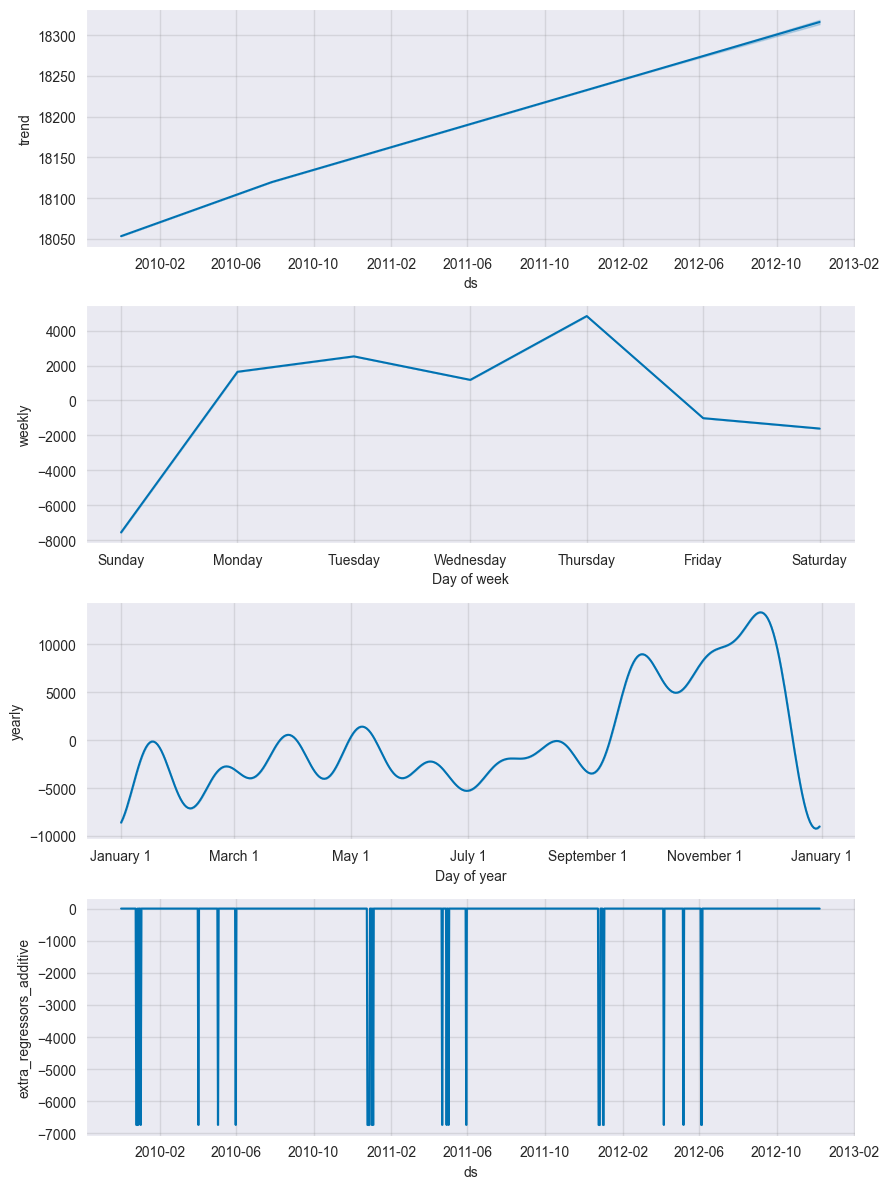

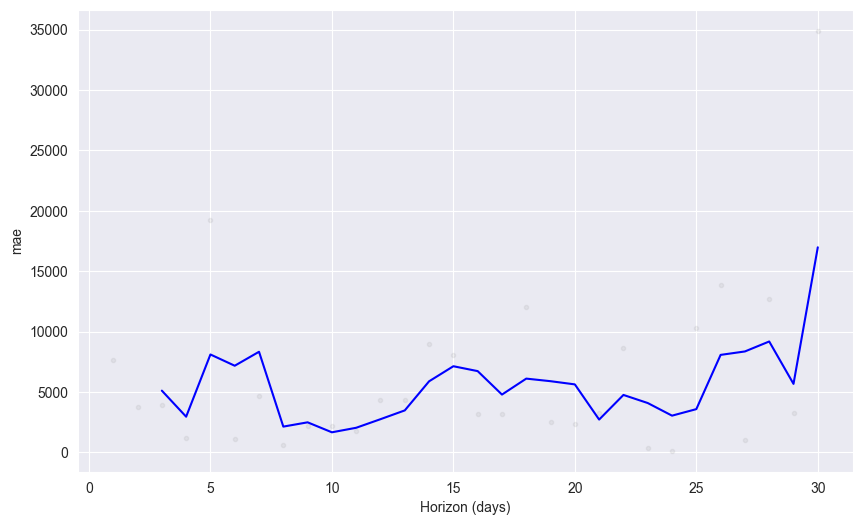

In [16]:
import itertools
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import holidays

# 1. Prepare Data
# data = df.copy()
# data["ds"] = df.index
# data["y"] = df["quantity_winsorized"]
# data['ds'] = pd.to_datetime(data['ds'])

# Add is_public_holiday column
holiday = holidays.CountryHoliday('UK')
data['is_public_holiday'] = data['ds'].apply(
    lambda date: 1 if date in holiday else 0
)

# Define hyperparameters to tune
param_grid = {  
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

best_params = None
best_mape = float('inf')

# Grid search to find the best hyperparameters
for params in all_params:
    model = Prophet(**params)
    model.add_regressor('is_public_holiday')
    model.fit(data)

    # Cross-validate the model
    df_cv = cross_validation(model, initial='547 days', period='180 days', horizon='30 days')
    df_p = performance_metrics(df_cv)
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(df_cv['y'], df_cv['yhat'])
    
    if mape < best_mape:
        best_mape = mape
        best_params = params

# Output the best parameters and MAPE
print(f"Best Parameters: {best_params}")
print(f"Best MAPE: {round(best_mape, 2)}")

# Train the final model with the best parameters
model = Prophet(**best_params)
model.add_regressor('is_public_holiday')
model.fit(data)

# Forecast future values
future = model.make_future_dataframe(periods=365)
future['is_public_holiday'] = future['ds'].apply(
    lambda date: 1 if date in holiday else 0
)

forecast = model.predict(future)

# Visualize Results
model.plot(forecast)
model.plot_components(forecast)

# Evaluate Accuracy
df_cv = cross_validation(model, initial='547 days', period='180 days', horizon='30 days')
df_p = performance_metrics(df_cv)
print(df_p.head().round(2))

fig = plot_cross_validation_metric(df_cv, metric='mae')

# Calculate MAPE using yhat and y
mape = mean_absolute_percentage_error(df_cv['y'], df_cv['yhat'])
print(f"MAPE: {round(mape, 3)}")


# Statistical Models

C:\Users\David\Documents\GitHub\smart-retail\ISO 2.0\backend\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\David\Documents\GitHub\smart-retail\ISO 2.0\backend\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 10740.52218469695
MAPE: 0.4483916055823523


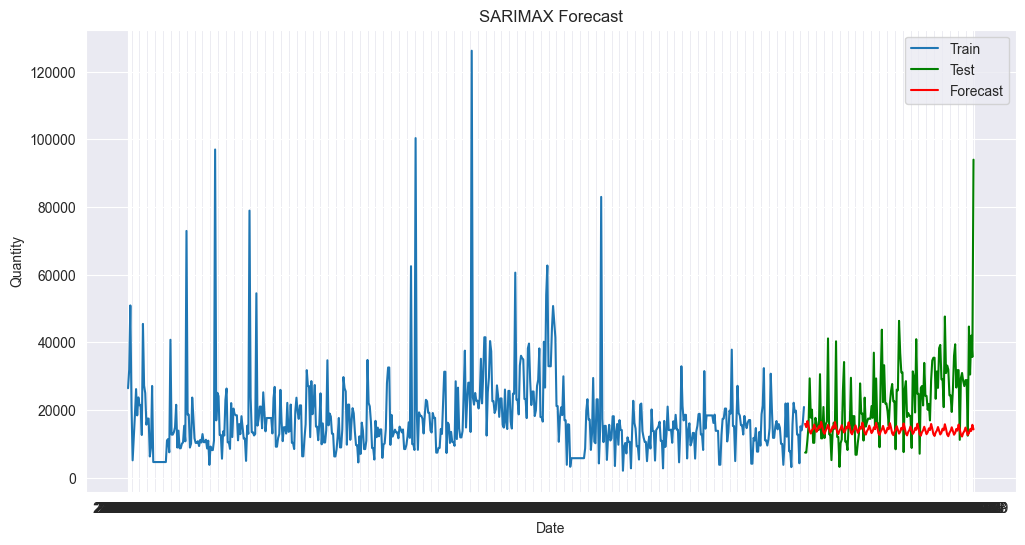

In [19]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

## Model 1 : SARIMAX
# Split data into train and test sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Define and fit the SARIMAX model
model = SARIMAX(train['quantity'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
fit_model = model.fit(disp=False)

# Forecast
n_forecast = len(test)
forecast = fit_model.get_forecast(steps=n_forecast)
forecast_index = test.index
forecast_values = forecast.predicted_mean

# Calculate MAE and MAPE
mae = mean_absolute_error(test['quantity'], forecast_values)
mape = mean_absolute_percentage_error(test['quantity'], forecast_values)

# Print the results
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['quantity'], label='Train')
plt.plot(test.index, test['quantity'], label='Test', color='green')
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('SARIMAX Forecast')
plt.legend()
plt.show()

### ARIMA & SES

C:\Users\David\Documents\GitHub\smart-retail\ISO 2.0\backend\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\David\Documents\GitHub\smart-retail\ISO 2.0\backend\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\David\Documents\GitHub\smart-retail\ISO 2.0\backend\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\David\Documents\GitHub\smart-retail\ISO 2.0\backend\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\David\D

ARIMA MAE: 10444.63540798757, ARIMA MAPE: 0.43786788782652103
Exponential Smoothing MAE: 10330.516549250999, Exponential Smoothing MAPE: 0.43601500770264295


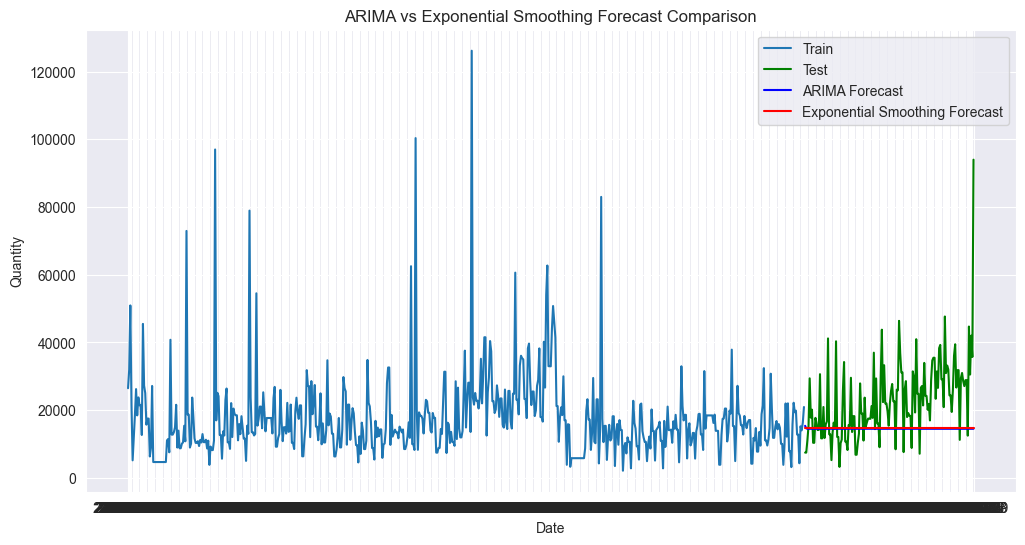

In [20]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing


# ARIMA Model
def fit_arima(train_data, order):
    model = ARIMA(train_data, order=order)
    fit_model = model.fit()
    return fit_model

# Exponential Smoothing (Simple Exponential Smoothing)
def fit_exponential_smoothing(train_data):
    model = SimpleExpSmoothing(train_data)
    fit_model = model.fit()
    return fit_model

# Forecasting and Evaluation Function
def forecast_and_evaluate(model, test_data):
    forecast_values = model.forecast(len(test_data))
    mae = mean_absolute_error(test_data, forecast_values)
    mape = mean_absolute_percentage_error(test_data, forecast_values)
    return forecast_values, mae, mape

# Fit ARIMA model
arima_model = fit_arima(train['quantity'], order=(1, 1, 1))

# Fit Exponential Smoothing model
exp_smoothing_model = fit_exponential_smoothing(train['quantity'])

# Forecast and evaluate ARIMA
arima_forecast, arima_mae, arima_mape = forecast_and_evaluate(arima_model, test['quantity'])

# Forecast and evaluate Exponential Smoothing
exp_smoothing_forecast, exp_smoothing_mae, exp_smoothing_mape = forecast_and_evaluate(exp_smoothing_model, test['quantity'])

# Print results
print(f'ARIMA MAE: {arima_mae}, ARIMA MAPE: {arima_mape}')
print(f'Exponential Smoothing MAE: {exp_smoothing_mae}, Exponential Smoothing MAPE: {exp_smoothing_mape}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['quantity'], label='Train')
plt.plot(test.index, test['quantity'], label='Test', color='green')

# Plot ARIMA forecast
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='blue')

# Plot Exponential Smoothing forecast
plt.plot(test.index, exp_smoothing_forecast, label='Exponential Smoothing Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('ARIMA vs Exponential Smoothing Forecast Comparison')
plt.legend()
plt.show();

AutoARIMA - MAE: 9334.1057, MAPE: 29.8733%
AutoETS - MAE: 6664.2523, MAPE: 25.4941%
AutoCES - MAE: 7582.7327, MAPE: 26.5709%
AutoTheta - MAE: 6604.7845, MAPE: 26.0612%
SESOpt - MAE: 6661.8000, MAPE: 25.5225%

The best model is AutoETS with a MAPE of 25.4941%


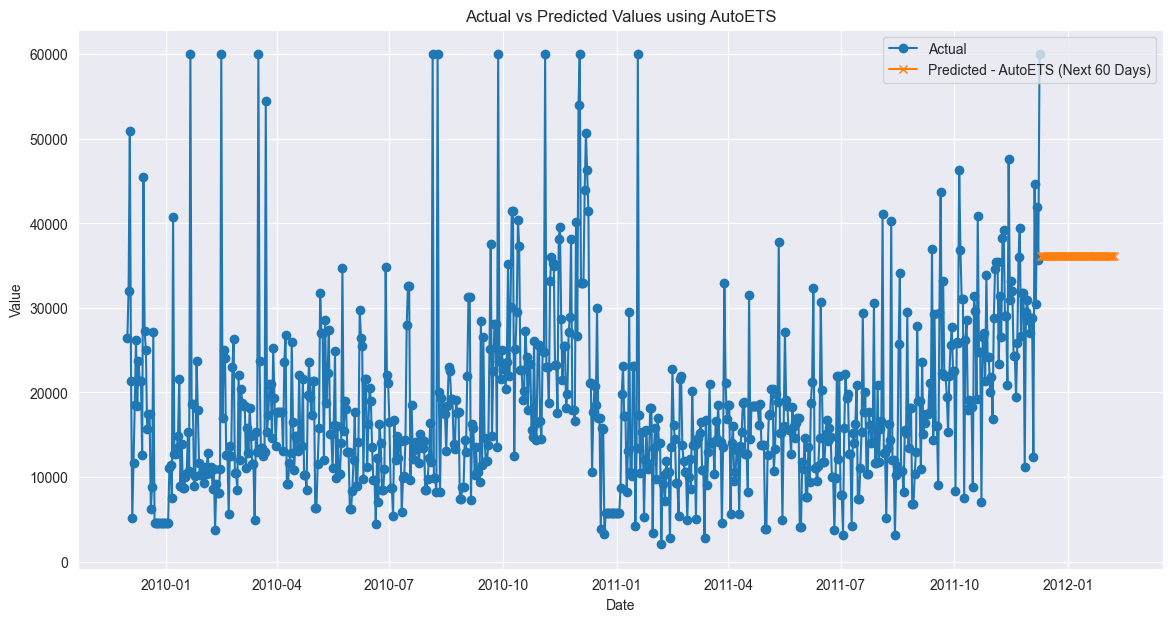


The best model is AutoETS with a MAPE of 25.4941%


In [22]:
import pandas as pd
import numpy as np
from statsforecast.models import AutoARIMA, AutoETS, AutoCES, AutoTheta, SimpleExponentialSmoothingOptimized
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
import matplotlib.pyplot as plt

# Assuming you have defined train_df, test_df, and ml_data somewhere in your code

# Extract the 'y' series from train and test dataframes
train_series = train_df['y'].values
test_series = test_df['y'].values

# Define the models
models = {
    'AutoARIMA': AutoARIMA(season_length=12),
    'AutoETS': AutoETS(model='ZZZ', season_length=12),
    'AutoCES': AutoCES(model='Z', season_length=12),
    'AutoTheta': AutoTheta(season_length=12),
    'SESOpt': SimpleExponentialSmoothingOptimized()
}

# Initialize lists to store results
mape_scores = []
mae_scores = []
forecasts_dict = {}

# Train and evaluate each model
for name, model in models.items():
    model = model.fit(y=train_series)
    forecasts = model.predict(h=len(test_series))
    forecasts_dict[name] = forecasts['mean']
    
    # Calculate MAPE and MAE
    mape = mean_absolute_percentage_error(test_series, forecasts['mean'])
    mae = mean_absolute_error(test_series, forecasts['mean'])
    
    mape_scores.append((name, mape))
    mae_scores.append((name, mae))
    
    print(f"{name} - MAE: {mae:.4f}, MAPE: {mape:.4%}")

# Select the best model based on MAPE
best_model_name, best_mape = min(mape_scores, key=lambda x: x[1])
best_model = models[best_model_name]

print(f"\nThe best model is {best_model_name} with a MAPE of {best_mape:.4%}")

# Train the best model on the entire dataset
best_model = best_model.fit(y=data['y'].values)

# Predict the next 60 days
future_forecasts = best_model.predict(h=60)

# Combine the historical data with the forecast data for plotting
combined_df = data.copy()
future_df = pd.DataFrame({
    'ds': pd.date_range(start=data['ds'].max() + pd.Timedelta(days=1), periods=60, freq='D'),
    'y': np.nan
})
combined_df = pd.concat([combined_df, future_df], ignore_index=True)
combined_df['forecast'] = np.nan
combined_df.loc[data.shape[0]:, 'forecast'] = future_forecasts['mean']

# Plot actual vs predicted values for the historical period and future forecast
plt.figure(figsize=(14, 7))

# Plot the entire dataset
plt.plot(combined_df['ds'], combined_df['y'], label='Actual', marker='o')

# Plot the future forecasts
plt.plot(
    combined_df['ds'],
    combined_df['forecast'],
    label=f'Predicted - {best_model_name} (Next 60 Days)',
    marker='x',
)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'Actual vs Predicted Values using {best_model_name}')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nThe best model is {best_model_name} with a MAPE of {best_mape:.4%}")


AutoARIMA - MAE: 9334.1057, MAPE: 29.8733%
AutoETS - MAE: 6664.2523, MAPE: 25.4941%
AutoCES - MAE: 7582.7327, MAPE: 26.5709%
AutoTheta - MAE: 6604.7845, MAPE: 26.0612%
SESOpt - MAE: 6661.8000, MAPE: 25.5225%

The best model is AutoETS with a MAPE of 25.4941%


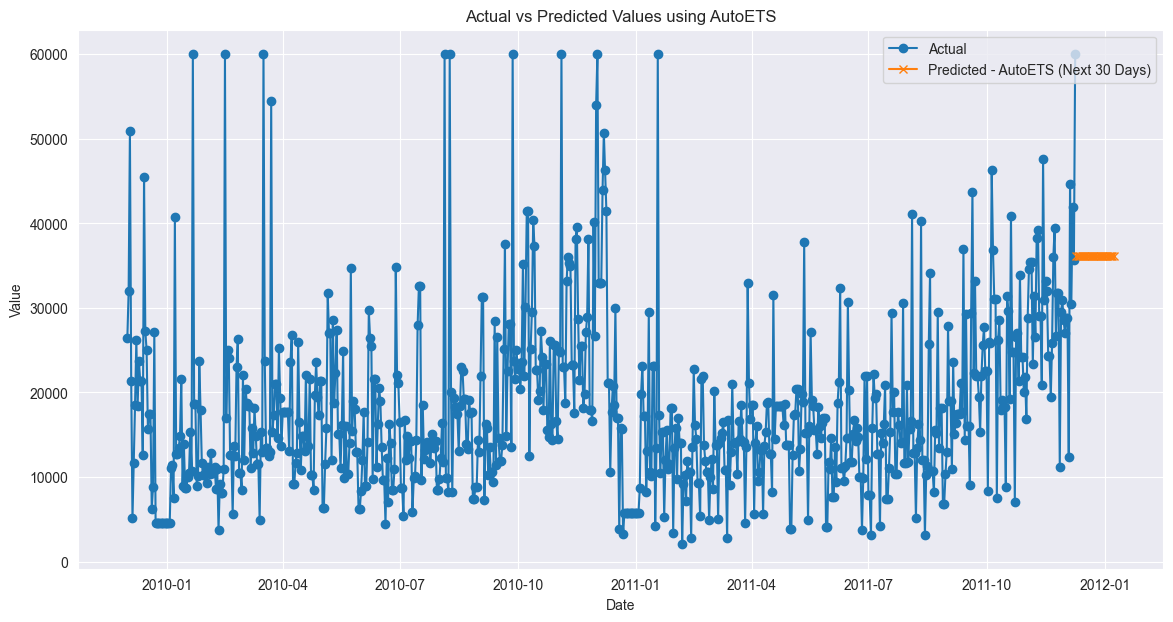


The best model is AutoETS with a MAPE of 25.4941%


In [24]:
import pandas as pd
import numpy as np
from statsforecast.models import AutoARIMA, AutoETS, AutoCES, AutoTheta, SimpleExponentialSmoothingOptimized
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
import matplotlib.pyplot as plt

# Assuming you have defined train_df, test_df, and ml_data somewhere in your code

# Extract the 'y' series from train and test dataframes
train_series = train_df['y'].values
test_series = test_df['y'].values

# Define the models
models = {
    'AutoARIMA': AutoARIMA(season_length=12),
    'AutoETS': AutoETS(model='ZZZ', season_length=12),
    'AutoCES': AutoCES(model='Z', season_length=12),
    'AutoTheta': AutoTheta(season_length=12),
    'SESOpt': SimpleExponentialSmoothingOptimized()
}

# Initialize lists to store results
mape_scores = []
mae_scores = []
forecasts_dict = {}

# Train and evaluate each model
for name, model in models.items():
    model = model.fit(y=train_series)
    forecasts = model.predict(h=len(test_series))
    forecasts_dict[name] = forecasts['mean']
    
    # Calculate MAPE and MAE
    mape = mean_absolute_percentage_error(test_series, forecasts['mean'])
    mae = mean_absolute_error(test_series, forecasts['mean'])
    
    mape_scores.append((name, mape))
    mae_scores.append((name, mae))
    
    print(f"{name} - MAE: {mae:.4f}, MAPE: {mape:.4%}")

# Select the best model based on MAPE
best_model_name, best_mape = min(mape_scores, key=lambda x: x[1])
best_model = models[best_model_name]

print(f"\nThe best model is {best_model_name} with a MAPE of {best_mape:.4%}")

# Train the best model on the entire dataset
best_model = best_model.fit(y=data['y'].values)

# Predict the next 30 days instead of 60
future_forecasts = best_model.predict(h=30)

# Combine the historical data with the forecast data for plotting
combined_df = data.copy()
future_df = pd.DataFrame({
    'ds': pd.date_range(start=data['ds'].max() + pd.Timedelta(days=1), periods=30, freq='D'),
    'y': np.nan
})
combined_df = pd.concat([combined_df, future_df], ignore_index=True)
combined_df['forecast'] = np.nan
combined_df.loc[data.shape[0]:, 'forecast'] = future_forecasts['mean']

# Plot actual vs predicted values for the historical period and future forecast
plt.figure(figsize=(14, 7))

# Plot the entire dataset
plt.plot(combined_df['ds'], combined_df['y'], label='Actual', marker='o')

# Plot the future forecasts
plt.plot(
    combined_df['ds'],
    combined_df['forecast'],
    label=f'Predicted - {best_model_name} (Next 30 Days)',
    marker='x',
)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'Actual vs Predicted Values using {best_model_name}')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nThe best model is {best_model_name} with a MAPE of {best_mape:.4%}")
